# TrustWeight: Complete Self-Contained Notebook

This notebook contains all code needed to run TrustWeight experiments:
- Library installation
- Data downloading and loading
- All TrustWeight implementation
- Logging and checkpointing

**Run cells sequentially from top to bottom.**

## Google Colab Setup
This notebook is configured to save all results (logs, checkpoints, models) to Google Drive.
Data will be downloaded locally for faster access.


## 1. Google Colab Setup (Mount Drive)

**Skip this section if running locally.**


In [72]:
import os

# Google Colab: Mount Google Drive
try:
    from google.colab import drive
    IN_COLAB = True
    # Mount Google Drive
    drive.mount('/content/drive')
    # Define the target directory for saving results
    OUTPUT_DIR = "/content/drive/MyDrive/colab/dml_project"
    # Create the directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✅ Google Drive mounted")
    print(f"✅ Output directory set to: {OUTPUT_DIR}")
    print(f"📁 All logs, checkpoints, and results will be saved to Google Drive")
except ImportError:
    IN_COLAB = False
    OUTPUT_DIR = None
    print("⚠️  Not running in Google Colab - using local paths")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
✅ Output directory set to: /content/drive/MyDrive/colab/dml_project
📁 All logs, checkpoints, and results will be saved to Google Drive


## 2. Import Libraries and Setup


In [73]:
# Install required packages (if not already installed)
%pip install torch torchvision pytorch-lightning pyyaml numpy matplotlib pandas -q
# Silence libraries
import os
import logging, warnings
os.environ["TQDM_DISABLE"] = "1"
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["LIGHTNING_DISABLE_RICH"] = "1"
for name in [
    "pytorch_lightning", "lightning", "lightning.pytorch",
    "lightning_fabric", "lightning_utilities", "torch", "torchvision",
]:
    logging.getLogger(name).setLevel(logging.ERROR)
    logging.getLogger(name).propagate = False
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
# Core imports
import time
import csv
import threading
import random
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import yaml
import pandas as pd
import matplotlib.pyplot as plt
# Setup paths based on environment
if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
    # Google Colab: Save everything to Drive except data
    BASE_OUTPUT_DIR = Path(OUTPUT_DIR)
    DATA_DIR = Path("./data")  # Local for faster access
    print(f"✅ Google Colab mode: Results → {BASE_OUTPUT_DIR}")
    print(f"✅ Data directory: {DATA_DIR} (local)")
else:
    # Local execution: Use current directory
    BASE_OUTPUT_DIR = Path(".")
    DATA_DIR = Path("./data")
    print(f"✅ Local mode: Results → {BASE_OUTPUT_DIR}")

print("✅ Libraries imported")




✅ Google Colab mode: Results → /content/drive/MyDrive/colab/dml_project
✅ Data directory: data (local)
✅ Libraries imported


## 3. Utility Functions


In [74]:
# ========== Helper Functions ==========

def set_seed(seed: int = 42) -> None:
    """Seed all RNGs for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device() -> torch.device:
    """Return the first available computation device (CUDA/MPS/CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")



In [75]:
# ========== Model Utilities ==========

def build_resnet18(num_classes: int = 10, pretrained: bool = False) -> nn.Module:
    """Create ResNet-18 adapted for CIFAR-10."""
    if pretrained:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=None)
    # CIFAR-10: 32x32 -> use 3x3 conv, stride 1, no maxpool
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    # Replace classifier
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    m.num_classes = num_classes
    return m


def state_to_list(state: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
    """Flatten a state_dict to a list of tensors on CPU."""
    return [t.detach().cpu().clone() for _, t in state.items()]


def list_to_state(template: Dict[str, torch.Tensor], arrs: List[torch.Tensor]) -> Dict[str, torch.Tensor]:
    """Rebuild a state_dict from a list of tensors using a template."""
    out: Dict[str, torch.Tensor] = {}
    for (k, v), a in zip(template.items(), arrs):
        out[k] = a.to(v.device).type_as(v)
    return out

print("✅ Model utilities defined")




✅ Model utilities defined


In [76]:
# ========== Data Loading and Partitioning ==========

class DataDistributor:
    """Data distributor for federated learning with Dirichlet partitioning."""

    def __init__(self, dataset_name: str, data_dir: str = "./data"):
        self.dataset_name = dataset_name.lower()
        self.data_dir = data_dir
        self.train_dataset, self.test_dataset, self.num_classes = self._load_dataset()
        self.partitions = None

    def _load_dataset(self) -> Tuple[Any, Any, int]:
        """Load CIFAR-10 dataset with augmentation."""
        if self.dataset_name == "cifar10":
            # Strong data pipeline: augmentation for train, normalization for test
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.4914, 0.4822, 0.4465),
                    std=(0.2470, 0.2435, 0.2616),
                ),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.4914, 0.4822, 0.4465),
                    std=(0.2470, 0.2435, 0.2616),
                ),
            ])
            train = datasets.CIFAR10(self.data_dir, train=True, download=True, transform=transform_train)
            test = datasets.CIFAR10(self.data_dir, train=False, download=True, transform=transform_test)
            num_classes = 10
        else:
            raise ValueError(f"Dataset '{self.dataset_name}' not supported. Use 'cifar10'.")
        return train, test, num_classes

    def distribute_data(self, num_clients: int, alpha: float = 0.5, seed: int = 42):
        """Partition data using Dirichlet distribution."""
        np.random.seed(seed)
        targets = np.array(self.train_dataset.targets)
        self.partitions = {i: [] for i in range(num_clients)}

        for cls in range(self.num_classes):
            idxs = np.where(targets == cls)[0]
            np.random.shuffle(idxs)
            proportions = np.random.dirichlet(alpha=np.repeat(alpha, num_clients))
            proportions = np.array([p * len(idxs) for p in proportions]).astype(int)

            # Handle leftover samples from integer rounding
            total_assigned = proportions.sum()
            leftover = len(idxs) - total_assigned
            if leftover > 0:
                # Distribute leftovers to random clients
                recipients = np.random.choice(num_clients, size=leftover, replace=True)
                for r in recipients:
                    proportions[r] += 1

            start = 0
            for client_id, size in enumerate(proportions):
                self.partitions[client_id].extend(idxs[start:start + size])
                start += size

        for cid in self.partitions:
            np.random.shuffle(self.partitions[cid])

    def get_client_data(self, client_id: int) -> Subset:
        """Get data subset for a specific client."""
        if self.partitions is None:
            raise ValueError("Data not distributed yet. Call distribute_data() first.")
        indices = self.partitions[client_id]
        return Subset(self.train_dataset, indices)

print("✅ DataDistributor class defined")




✅ DataDistributor class defined


## 4. TrustWeight Client Implementation


In [77]:
# Lightning-free async federated client for CIFAR-10
import time
import random
from typing import Sequence, Tuple

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_


# build_resnet18 already defined
# get_device already defined




def _build_transform() -> transforms.Compose:
    """Build CIFAR-10 training transform (matches DataDistributor._load_dataset)."""
    # CIFAR-10 standard augmentation to reduce overfitting
    return transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ]
    )


def _make_dataloader(
    data_dir: str,
    indices: Sequence[int],
    batch_size: int,
) -> DataLoader:
    dataset = datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=False,
        transform=_build_transform(),
    )
    subset = Subset(dataset, indices)

    # Safety: in case partitioning ever returns an empty list for a client
    if len(subset) == 0:
        return DataLoader(subset, batch_size=1, shuffle=False, num_workers=0)

    # num_workers=0 to avoid multiprocessing issues on macOS / Python 3.13
    return DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0)


class AsyncClient:
    """Asynchronous client performing local training on its partition.

    The client fetches the latest global model from the server, trains for a few
    local epochs, and submits the updated parameters plus basic telemetry.
    """

    def __init__(
        self,
        cid: int,
        indices: Sequence[int],
        cfg: dict,
    ) -> None:
        self.cid = cid
        self.cfg = cfg
        self.device = get_device()
        self.loader = _make_dataloader(
            cfg["data"]["data_dir"],
            indices,
            cfg["clients"]["batch_size"],
        )
        self.num_classes = cfg["data"]["num_classes"]
        self.lr = cfg["clients"]["lr"]
        self.weight_decay = cfg["clients"]["weight_decay"]
        self.grad_clip = cfg["clients"]["grad_clip"]

        # --- straggler behaviour ---
        num_clients = cfg["clients"]["total"]
        slow_fraction = cfg["clients"].get("struggle_percent", 0) / 100.0
        num_slow = int(round(num_clients * slow_fraction))
        self.is_slow = cid < num_slow  # deterministic but good enough

        # Reduce epochs for slow clients (straggler robustness)
        base_epochs = cfg["clients"]["local_epochs"]
        if self.is_slow:
            self.local_epochs = max(1, base_epochs // 2)  # half epochs for slow clients
        else:
            self.local_epochs = base_epochs

        self.delay_slow_range = tuple(cfg["clients"].get("delay_slow_range", [0.8, 2.0]))
        self.delay_fast_range = tuple(cfg["clients"].get("delay_fast_range", [0.0, 0.2]))
        self.jitter_per_round = float(cfg["clients"].get("jitter_per_round", 0.0))
        self.client_delay = float(cfg.get("server_runtime", {}).get("client_delay", 0.0))

    # ------------------------------------------------------------------ utils

    def _sample_delay(self) -> float:
        if self.is_slow:
            base = random.uniform(*self.delay_slow_range)
        else:
            base = random.uniform(*self.delay_fast_range)
        jitter = random.uniform(-self.jitter_per_round, self.jitter_per_round)
        return max(0.0, base + jitter + self.client_delay)

    def _build_model(self) -> nn.Module:
        model = build_resnet18(num_classes=self.num_classes)
        return model.to(self.device)

    # ---------------------------------------------------------------- training

    def _evaluate_on_loader(self, model: nn.Module) -> Tuple[float, float]:
        """Return (loss, accuracy) on the client's local data."""
        model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        total_correct = 0
        total_examples = 0
        with torch.no_grad():
            for xb, yb in self.loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                logits = model(xb)
                loss = criterion(logits, yb)
                total_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                total_correct += (preds == yb).sum().item()
                total_examples += xb.size(0)
        if total_examples == 0:
            return 0.0, 0.0
        return total_loss / total_examples, total_correct / total_examples

    def _train_local(self, model: nn.Module) -> Tuple[float, float]:
        """Train for `local_epochs` and return (loss_after, acc_after)."""
        model.train()
        criterion = nn.CrossEntropyLoss()
        # Use momentum from config (defaults to 0.0 if not specified)
        client_momentum = self.cfg.get("clients", {}).get("momentum", 0.0)
        optim = torch.optim.SGD(
            model.parameters(),
            lr=self.lr,
            momentum=client_momentum,
            weight_decay=self.weight_decay,
        )

        for _ in range(self.local_epochs):
            for xb, yb in self.loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optim.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                if self.grad_clip > 0:
                    clip_grad_norm_(model.parameters(), self.grad_clip)
                optim.step()

        # reuse evaluation code for final metrics
        return self._evaluate_on_loader(model)

    # ------------------------------------------------------------- main loop

    def run_once(self, server) -> bool:
        """Perform a single async round with the server.

        Returns False when the server indicates global stopping, True otherwise.
        """
        # Simulated network / computation delay heterogeneity
        delay = self._sample_delay()
        if delay > 0:
            time.sleep(delay)

        if server.should_stop():
            return False

        # Get the latest global model snapshot
        version, global_state = server.get_global_model()
        model = self._build_model()
        model.load_state_dict(global_state)

        # Evaluate before local training to compute loss drop ΔL̃_i
        loss_before, _ = self._evaluate_on_loader(model)

        start_time = time.time()
        loss_after, train_acc = self._train_local(model)
        train_time_s = time.time() - start_time

        # Local "test" is just another pass over the client's data
        test_loss, test_acc = self._evaluate_on_loader(model)

        # Move params to CPU tensors so they are cheap to share with server
        # Build an OrderedDict for ``new_params`` using the model's own
        # parameter ordering.  Although Python's plain dicts preserve
        # insertion order, explicitly constructing an ``OrderedDict`` makes
        # the intent clear and avoids any surprises if the language
        # specification changes.  The server relies on matching key
        # ordering to correctly flatten parameter tensors.
        from collections import OrderedDict
        new_params = OrderedDict()
        for k, v in model.state_dict().items():
            new_params[k] = v.detach().cpu().clone()
        num_examples = len(self.loader.dataset)

        delta_loss = loss_before - loss_after  # ΔL̃_i

        # All local metrics are computed here and passed to the server
        server.submit_update(
            client_id=self.cid,
            base_version=version,
            new_params=new_params,
            num_samples=num_examples,
            train_time_s=train_time_s,
            delta_loss=delta_loss,
            loss_before=loss_before,
            loss_after=loss_after,
            train_acc=train_acc,
            test_loss=test_loss,
            test_acc=test_acc,
        )
        return not server.should_stop()


print("✅ TrustWeight client implementation defined")



✅ TrustWeight client implementation defined


In [78]:
# ========== TrustWeight Strategy Implementation ==========
# Adapted from TrustWeight/strategy.py for notebook use

# Trust-weighted asynchronous aggregation strategy implementing the PDF math
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import torch


@dataclass
class TrustWeightedConfig:
    eta: float = 1.0              # server learning rate η
    eps: float = 1e-8             # numerical stability ε
    freshness_alpha: float = 0.1  # α in s(τ) = exp(-α τ)
    beta1: float = 0.0            # Guard term coefficient on staleness
    beta2: float = 0.0            # Guard term coefficient on ||u||
    momentum_gamma: float = 0.9   # update factor for m_t
    theta: Tuple[float, float, float] = (0.0, 0.0, 0.0)  # quality weights


class TrustWeightedAsyncStrategy:
    """Implements the aggregation rule described in the DML solution PDF.

    Core formula:

        w_{t+1} = w_t + η * Σ_i Weight_i *
            [ Proj_m_t(u_i) + Guard_i * (u_i - Proj_m_t(u_i)) ]

    with:

        Proj_m_t(u_i) = <u_i, m_t> / (||m_t||^2 + eps) * m_t
        Guard_i = 1 / (1 + β1 * τ_i + β2 * ||u_i||)
        Weight_i ∝ s(τ_i) * exp(θᵀ [ΔL̃_i, ||u_i||, cos(u_i, m_t)]) * (n_i / Σ_j n_j)
    """

    def __init__(self, dim: int, cfg: TrustWeightedConfig | None = None) -> None:
        self.dim = int(dim)
        self.cfg = cfg or TrustWeightedConfig()
        self.m = torch.zeros(self.dim, dtype=torch.float32)  # m_t, server momentum
        self.step: int = 0

        self.theta = torch.tensor(self.cfg.theta, dtype=torch.float32)

    # ------------------------------------------------------------------ helpers

    def _proj_m(self, u: torch.Tensor) -> torch.Tensor:
        # Proj_m(u) = <u, m> / (||m||^2 + eps) * m
        num = torch.dot(u, self.m)
        denom = torch.dot(self.m, self.m) + self.cfg.eps
        coef = num / denom
        return coef * self.m

    def _guard(self, tau: torch.Tensor, norm_u: torch.Tensor) -> torch.Tensor:
        # Guard_i = 1 / (1 + β1 τ_i + β2 ||u_i||)
        return 1.0 / (1.0 + self.cfg.beta1 * tau + self.cfg.beta2 * norm_u)

    def _freshness(self, tau: torch.Tensor) -> torch.Tensor:
        # s(τ) = exp(-α τ)
        return torch.exp(-self.cfg.freshness_alpha * tau)

    # ---------------------------------------------------------------- aggregate

    def aggregate(
        self,
        w_t: torch.Tensor,
        updates: List[Dict[str, torch.Tensor]],
        use_sample_weighing: bool = True,
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """Aggregate a buffer of updates.

        Args:
            w_t: Flattened current global model.
            updates: List of dicts, each containing:
                {
                    "u": update vector (1D tensor),
                    "tau": scalar tensor τ_i,
                    "num_samples": scalar tensor n_i,
                    "delta_loss": scalar tensor ΔL̃_i,
                }

        Returns:
            new_w: updated global model vector.
            metrics: small dict with aggregation statistics.
        """
        if not updates:
            return w_t, {"avg_tau": 0.0, "buffer_size": 0.0}

        self.step += 1
        device = w_t.device
        self.m = self.m.to(device)

        # Collect basic statistics
        taus = torch.stack([u["tau"].to(device) for u in updates])  # [B]
        ns = torch.stack([u["num_samples"].to(device) for u in updates])  # [B]
        delta_losses = torch.stack([u["delta_loss"].to(device) for u in updates])  # [B]
        total_n = ns.sum().clamp_min(1.0)

        # Precompute norms, projections, sideways components, cosines
        proj_list: List[torch.Tensor] = []
        side_list: List[torch.Tensor] = []
        norm_u_list: List[torch.Tensor] = []
        cos_list: List[torch.Tensor] = []

        for u_rec in updates:
            u = u_rec["u"].to(device)
            norm_u = torch.norm(u).clamp_min(self.cfg.eps)
            norm_u_list.append(norm_u)

            proj = self._proj_m(u)
            side = u - proj
            proj_list.append(proj)
            side_list.append(side)

            # cos(u, m) = <u, m> / (||u|| ||m|| + eps)
            norm_m = torch.norm(self.m)
            if norm_m.item() > 0.0:
                cos_val = torch.dot(u, self.m) / (norm_u * norm_m + self.cfg.eps)
            else:
                cos_val = torch.tensor(0.0, device=device)
            cos_list.append(cos_val)

        norm_u_tensor = torch.stack(norm_u_list)  # [B]
        cos_tensor = torch.stack(cos_list)  # [B]

        # Guard factors per update
        guards = self._guard(taus, norm_u_tensor)  # [B]

        # Freshness
        freshness = self._freshness(taus)  # [B]

        # Add scaled staleness as a negative feature (straggler robustness)
        lambda_stale = 0.05
        effective_delta = delta_losses - lambda_stale * taus

        # Quality term: exp(θᵀ [ΔL̃_i, ||u_i||, cos(u_i, m_t)])
        # θ: (ΔL weight, -‖u‖ penalty, cosine alignment)
        feats = torch.stack(
            [effective_delta, norm_u_tensor, cos_tensor],
            dim=1,
        )  # [B, 3]
        quality_logits = feats @ self.theta.to(device)

        # Clamp logits to avoid exploding weights (straggler robustness)
        quality_logits = torch.clamp(quality_logits, min=-3.0, max=3.0)
        quality = torch.exp(quality_logits)

        # Data share term: n_i / Σ_j n_j (if use_sample_weighing) or uniform (1/|B|)
        if use_sample_weighing:
            data_share = ns / total_n  # [B]
        else:
            data_share = torch.ones_like(ns) / len(updates)  # [B]

        # Unnormalized weights, then normalization over buffer
        raw_weights = freshness * quality * data_share  # [B]
        sum_raw = raw_weights.sum()
        if sum_raw.item() <= 0.0:
            weights = torch.full_like(raw_weights, 1.0 / len(updates))
        else:
            weights = raw_weights / sum_raw

        # Combine projection and guarded sideways components
        agg_update = torch.zeros_like(w_t)
        for i in range(len(updates)):
            comp = proj_list[i] + guards[i] * side_list[i]
            agg_update = agg_update + weights[i] * comp

        # Final aggregation step:
        # w_{t+1} = w_t + η * Σ_i Weight_i * [Proj_m(u_i) + Guard_i (u_i - Proj_m(u_i))]
        new_w = w_t + self.cfg.eta * agg_update

        # Update momentum m_t as a running average of aggregated updates
        self.m = (1.0 - self.cfg.momentum_gamma) * self.m + self.cfg.momentum_gamma * agg_update

        metrics = {
            "avg_tau": float(taus.mean().item()),
            "avg_norm_u": float(norm_u_tensor.mean().item()),
            "avg_delta_loss": float(delta_losses.mean().item()),
            "buffer_size": float(len(updates)),
        }
        return new_w, metrics


print("✅ TrustWeight strategy implementation defined")




✅ TrustWeight strategy implementation defined


In [79]:
# ========== TrustWeight Server Implementation ==========
# Adapted from TrustWeight/server.py for notebook use

from collections import OrderedDict as ODType
from dataclasses import dataclass

def _testloader(root: str, batch_size: int = 256) -> DataLoader:
    """Create test dataloader."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    ds = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)

def _flatten_state(state: ODType[str, torch.Tensor]) -> torch.Tensor:
    """Flatten a state_dict into a 1D tensor."""
    return torch.cat([p.reshape(-1) for p in state.values()])

def _flatten_state_by_template(
    state: Dict[str, torch.Tensor], template: ODType[str, torch.Tensor]
) -> torch.Tensor:
    """Flatten state according to template key ordering."""
    return torch.cat([state[k].reshape(-1) for k in template.keys()])

def _vector_to_state(
    vec: torch.Tensor, template: ODType[str, torch.Tensor]
) -> ODType[str, torch.Tensor]:
    """Convert flattened vector back to state_dict."""
    new_state: ODType[str, torch.Tensor] = type(template)()
    offset = 0
    for k, t in template.items():
        numel = t.numel()
        new_state[k] = vec[offset : offset + numel].view_as(t).clone()
        offset += numel
    assert offset == vec.numel()
    return new_state

@dataclass
class ClientUpdateState:
    """State for a client update."""
    client_id: int
    base_version: int
    new_params: ODType[str, torch.Tensor]
    num_samples: int
    train_time_s: float
    delta_loss: float
    loss_before: float
    loss_after: float
    train_acc: float
    test_loss: float
    test_acc: float
    arrival_ts: float

class AsyncServer:
    """Central server maintaining global model and asynchronous buffer."""

    def __init__(
        self,
        global_model: torch.nn.Module,
buffer_size: int = 5,
        buffer_timeout_s: float = 5.0,
        use_sample_weighing: bool = True,
        target_accuracy: float = 0.8,
        max_rounds: Optional[int] = None,
data_dir: str = "./data",
logs_dir: str = "./logs/TrustWeight",
        global_log_csv: Optional[str] = None,
        client_participation_csv: Optional[str] = None,
resume: bool = True,
        device: Optional[torch.device] = None,
        freshness_alpha: float = 0.1,
        beta1: float = 0.0,
        beta2: float = 0.0,
        eta: float = 1.0,
        theta: Optional[Tuple[float, float, float]] = None,
    ):
        self.device = device or get_device()

        # Extract num_classes from global_model
        # Try to get it from model attribute, or infer from fc layer
        if hasattr(global_model, 'num_classes'):
            self.num_classes = global_model.num_classes
        elif hasattr(global_model, 'fc'):
            self.num_classes = global_model.fc.out_features
        else:
            # Default for CIFAR-10
            self.num_classes = 10

        # data / evaluation
        self.testloader = _testloader(data_dir, batch_size=256)

        # global model and version history
        self._template_state: ODType[str, torch.Tensor] = ODType(
            (k, v.detach().cpu().clone()) for k, v in global_model.state_dict().items()
        )
        self._global_state: ODType[str, torch.Tensor] = ODType(
            (k, v.clone()) for k, v in self._template_state.items()
        )

        self._model_versions: List[ODType[str, torch.Tensor]] = [
            ODType((k, v.clone()) for k, v in self._global_state.items())
        ]
        self._version: int = 0

        # strategy encapsulating all math - use eta, theta, freshness_alpha, beta1, beta2 from config
        dim = _flatten_state(self._global_state).numel()
        # θ: (ΔL weight, -‖u‖ penalty, cosine alignment)
        theta_cfg = theta if theta is not None else (1.0, -0.1, 0.2)
        strategy_cfg = TrustWeightedConfig(
            eta=eta,
            theta=theta_cfg,
            freshness_alpha=freshness_alpha,
            beta1=beta1,
            beta2=beta2,
        )
        self.strategy = TrustWeightedAsyncStrategy(dim=dim, cfg=strategy_cfg)
        self.eta = eta
        self.theta = theta_cfg
        self.use_sample_weighing = use_sample_weighing

        # async buffer
        self.buffer: List[ClientUpdateState] = []
        self.buffer_size: int = buffer_size
        self.buffer_timeout_s: float = buffer_timeout_s
        self._last_flush_ts: float = time.time()

        # logging / control
        self.global_log_path = Path(global_log_csv) if global_log_csv else Path(logs_dir) / "TrustWeight.csv"
        self.global_log_path.parent.mkdir(parents=True, exist_ok=True)
        self._init_global_log()

        self.client_log_path = Path(client_participation_csv) if client_participation_csv else Path(logs_dir) / "TrustWeightClientParticipation.csv"
        self.client_log_path.parent.mkdir(parents=True, exist_ok=True)
        self._init_client_log()

        self.target_accuracy: float = target_accuracy
        self.max_rounds: int = max_rounds if max_rounds is not None else 1000
        self.update_clip_norm: float = 10.0  # Default clipping norm

        self._num_aggregations: int = 0
        self._stop: bool = False
        self._stop_reason: str = ""
        self._lock = threading.Lock()
        self._agg_lock = threading.Lock()
        self._start_ts: float = time.time()


    def _init_global_log(self) -> None:
        """Initialize the global training CSV."""
        if self.global_log_path.exists():
            return
        with self.global_log_path.open("w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "total_agg", "avg_train_loss", "avg_train_acc",
                "test_loss", "test_acc", "time",
            ])

    def _append_global_log(
        self,
        total_agg: int,
        avg_train_loss: float,
        avg_train_acc: float,
        test_loss: float,
        test_acc: float,
    ) -> None:
        """Append a single aggregation row to the global CSV."""
        ts = time.time() - self._start_ts
        with self.global_log_path.open("a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                int(total_agg),
                float(avg_train_loss),
                float(avg_train_acc),
                float(test_loss),
                float(test_acc),
                ts,
            ])

    def _init_client_log(self) -> None:
        """Initialize the client participation CSV."""
        if self.client_log_path.exists():
            return
        with self.client_log_path.open("w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "client_id", "local_train_loss", "local_train_acc",
                "local_test_loss", "local_test_acc", "total_agg", "staleness",
            ])

    def _append_client_participation_log(
        self,
        total_agg: int,
        updates: List[ClientUpdateState],
        staleness_list: List[float],
    ) -> None:
        """Append one row per client update."""
        with self.client_log_path.open("a", newline="") as f:
            writer = csv.writer(f)
            for u, tau_i in zip(updates, staleness_list):
                writer.writerow([
                    int(u.client_id),
                    float(u.loss_after),
                    float(u.train_acc),
                    float(u.test_loss),
                    float(u.test_acc),
                    int(total_agg),
                    float(tau_i),
                ])

    def should_stop(self) -> bool:
        with self._lock:
            return self._stop

    def mark_stop(self, reason: str = "") -> None:
        with self._lock:
            if not self._stop:
                self._stop = True
                if reason:
                    self._stop_reason = reason
                print(f"[Server] Stopping: {self._stop_reason}")

    def get_global_model(self) -> Tuple[int, Dict[str, torch.Tensor]]:
        """Return (version, state_dict) of the current global model."""
        with self._lock:
            version = self._version
            state = ODType((k, v.clone()) for k, v in self._global_state.items())
        return version, state

    def _make_model_from_state(self, state: Dict[str, torch.Tensor], num_classes: int) -> torch.nn.Module:
        model = build_resnet18(num_classes=num_classes)
        model.load_state_dict(state)
        return model.to(self.device)

    def _evaluate_global(self, num_classes: int) -> Tuple[float, float]:
        """Evaluate the current global model on the test set."""
        model = self._make_model_from_state(self._global_state, num_classes)
        model.eval()
        criterion = torch.nn.CrossEntropyLoss()
        total_loss = 0.0
        total_correct = 0
        total_examples = 0
        with torch.no_grad():
            for xb, yb in self.testloader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                logits = model(xb)
                loss = criterion(logits, yb)
                total_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                total_correct += (preds == yb).sum().item()
                total_examples += xb.size(0)
        if total_examples == 0:
            return 0.0, 0.0
        return total_loss / total_examples, total_correct / total_examples

    def _flush_buffer_if_needed(self) -> None:
        now = time.time()
        should_flush = False
        if len(self.buffer) >= self.buffer_size:
            should_flush = True
        elif (now - self._last_flush_ts) >= self.buffer_timeout_s and self.buffer:
            should_flush = True

        if not should_flush:
            return

        # copy buffer locally under lock then release for heavy work
        with self._lock:
            buffer_copy = list(self.buffer)
            self.buffer.clear()
            self._last_flush_ts = now

        # Serialize aggregations to avoid version races
        with self._agg_lock:
            self._aggregate(buffer_copy)

    def _aggregate(self, updates: List[ClientUpdateState]) -> None:
        """Aggregate a batch of client updates and log to CSVs."""
        if not updates:
            return

        # Snapshot of current global parameters and version history
        with self._lock:
            global_vec = _flatten_state_by_template(self._global_state, self._template_state)
            version_now = self._version
            model_versions = list(self._model_versions)

        # Construct per-update vectors and metadata for the strategy
        update_vectors: List[Dict[str, torch.Tensor]] = []
        staleness_list: List[float] = []
        valid_updates: List[ClientUpdateState] = []

        for u in updates:
            base_state = model_versions[u.base_version]
            base_vec = _flatten_state_by_template(base_state, self._template_state)
            new_vec = _flatten_state_by_template(u.new_params, self._template_state)
            ui = new_vec - base_vec

            # Skip bad updates
            if not torch.isfinite(ui).all():
                print(f"[Server] Dropping client {u.client_id} update due to NaN/Inf values")
                continue
            if self.update_clip_norm > 0:
                norm = torch.norm(ui)
                if torch.isfinite(norm) and norm.item() > self.update_clip_norm:
                    ui = ui * (self.update_clip_norm / (norm + 1e-12))

            # τ_i = version-based staleness (how many global updates since client started)
            tau_i = float(max(0, version_now - u.base_version))

            # Drop extremely stale updates (hard threshold for straggler robustness)
            max_tau = 10.0
            if tau_i > max_tau:
                print(f"[Server] Dropping client {u.client_id} update (tau={tau_i:.1f} > {max_tau})")
                continue

            staleness_list.append(tau_i)

            delta_loss = float(u.delta_loss)
            update_vectors.append({
                "u": ui,
                "tau": torch.tensor(tau_i, dtype=torch.float32),
                "num_samples": torch.tensor(float(u.num_samples), dtype=torch.float32),
                "delta_loss": torch.tensor(delta_loss, dtype=torch.float32),
            })
            valid_updates.append(u)

        if not update_vectors:
            print("[Server] Buffer flush skipped: no valid updates after filtering.")
            return

        # Run the trust-weighted aggregation strategy
        new_global_vec, agg_metrics = self.strategy.aggregate(
            global_vec, update_vectors, use_sample_weighing=self.use_sample_weighing
        )

        # Map back into parameter state_dict form
        new_state = _vector_to_state(new_global_vec, self._template_state)

        # Compute average local train metrics
        avg_train_loss = sum(u.loss_after for u in valid_updates) / len(valid_updates)
        avg_train_acc = sum(u.train_acc for u in valid_updates) / len(valid_updates)

        # Commit the new global model
        with self._lock:
            self._global_state = ODType((k, v.clone()) for k, v in new_state.items())
            self._model_versions.append(
                ODType((k, v.clone()) for k, v in self._global_state.items())
            )
            self._version = len(self._model_versions) - 1
            self._num_aggregations += 1
            total_agg = self._num_aggregations

        # Evaluate updated global model
        test_loss, test_acc = self._evaluate_global(self.num_classes)

        # Log metrics
        self._append_global_log(
            total_agg=total_agg,
            avg_train_loss=avg_train_loss,
            avg_train_acc=avg_train_acc,
            test_loss=test_loss,
            test_acc=test_acc,
        )
        self._append_client_participation_log(
            total_agg=total_agg,
            updates=valid_updates,
            staleness_list=staleness_list,
        )

        print(
            f"[Server] Aggregated {len(valid_updates)} updates -> agg={total_agg} "
            f"(avg_tau={agg_metrics.get('avg_tau', 0.0):.3f}, "
            f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f})"
        )

        # Stopping conditions
        if test_acc >= self.target_accuracy:
            self.mark_stop(f"target accuracy {test_acc:.4f} reached")
        if total_agg >= self.max_rounds:
            self.mark_stop("max aggregation rounds reached")

    def submit_update(
        self,
        client_id: int,
        base_version: int,
        new_params: Dict[str, torch.Tensor],
        num_samples: int,
        train_time_s: float,
        delta_loss: float,
        loss_before: float,
        loss_after: float,
        train_acc: float,
        test_loss: float,
        test_acc: float,
    ) -> None:
        """Entry point called by clients after local training."""
        cu = ClientUpdateState(
            client_id=client_id,
            base_version=base_version,
            new_params=new_params,
            num_samples=num_samples,
            train_time_s=float(train_time_s),
            delta_loss=float(delta_loss),
            loss_before=float(loss_before),
            loss_after=float(loss_after),
            train_acc=float(train_acc),
            test_loss=float(test_loss),
            test_acc=float(test_acc),
            arrival_ts=time.time(),
        )
        with self._lock:
            self.buffer.append(cu)
        self._flush_buffer_if_needed()

    def wait(self) -> None:
        """Block until training is finished."""
        try:
            while not self.should_stop():
                time.sleep(0.2)
        finally:
            self.mark_stop(self._stop_reason or "training finished")

print("✅ TrustWeight server implementation defined")





✅ TrustWeight server implementation defined


In [80]:
# ========== All 6 Experiment Configurations ==========

# Helper function to get paths (works for both Colab and local)
def get_paths(exp_id: str):
    """Get paths for experiment, using Google Drive if in Colab."""
    if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
        base = BASE_OUTPUT_DIR
    else:
        base = Path(".")

    return {
        "data_dir": str(DATA_DIR),  # Always local for faster access
        "checkpoints_dir": str(base / "checkpoints" / "TrustWeight" / exp_id),
        "logs_dir": str(base / "logs" / "TrustWeight" / exp_id),
        "results_dir": str(base / "results" / "TrustWeight" / exp_id),
    }

experiments = {
    "Exp1": {
        "name": "IID (alpha=1000), no stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),  # Use DATA_DIR variable
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 0,
            "delay_slow_range": [0.0, 0.0],
            "delay_fast_range": [0.0, 0.0],
            "jitter_per_round": 0.0,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.5,
            "theta": [1.0, -0.1, 0.2],
            "freshness_alpha": 0.1,
            "beta1": 0.0,
            "beta2": 0.0
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 1000.0,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp1")
    },
    "Exp2": {
        "name": "alpha=0.1, 10% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 10,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.5,
            "theta": [1.0, -0.1, 0.2],
            "freshness_alpha": 0.1,
            "beta1": 0.0,
            "beta2": 0.0
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp2")
    },
    "Exp3": {
        "name": "alpha=0.1, 20% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 20,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.5,
            "theta": [1.0, -0.1, 0.2],
            "freshness_alpha": 0.1,
            "beta1": 0.0,
            "beta2": 0.0
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp3")
    },
    "Exp4": {
        "name": "alpha=0.1, 30% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 30,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.5,
            "theta": [1.0, -0.1, 0.2],
            "freshness_alpha": 0.1,
            "beta1": 0.0,
            "beta2": 0.0
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp4")
    },
    "Exp5": {
        "name": "alpha=0.1, 40% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 40,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.4,
            "theta": [0.8, -0.05, 0.1],
            "freshness_alpha": 0.3,
            "beta1": 0.15,
            "beta2": 0.02
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp5")
    },
    "Exp6": {
        "name": "alpha=0.1, 50% stragglers",
        "data": {
            "dataset": "cifar10",
            "data_dir": str(DATA_DIR),
            "num_classes": 10
        },
        "clients": {
            "total": 20,
            "concurrent": 5,
            "local_epochs": 1,
            "batch_size": 128,
            "lr": 0.005,
            "momentum": 0.0,
            "weight_decay": 0.001,
            "grad_clip": 5.0,
            "struggle_percent": 50,
            "delay_slow_range": [0.8, 2.0],
            "delay_fast_range": [0.0, 0.2],
            "jitter_per_round": 0.05,
            "fix_delays_per_client": True
        },
        "trustweight": {
            "buffer_size": 5,
            "buffer_timeout_s": 0.0,
            "use_sample_weighing": True,
            "eta": 0.4,
            "theta": [0.8, -0.05, 0.1],
            "freshness_alpha": 0.3,
            "beta1": 0.15,
            "beta2": 0.02
        },
        "eval": {
            "interval_seconds": 1.0,
            "target_accuracy": 0.8
        },
        "train": {
            "max_rounds": 500
        },
        "partition_alpha": 0.1,
        "seed": 1,
        "server_runtime": {
            "client_delay": 0.0
        },
        "io": get_paths("Exp6")
    }
}

print("✅ All 6 experiment configurations loaded:")
for exp_id, exp_config in experiments.items():
    print(f"  {exp_id}: {exp_config['name']}")
    print(f"    - Alpha: {exp_config['partition_alpha']}")
    print(f"    - Stragglers: {exp_config['clients']['struggle_percent']}%")
    print(f"    - Max rounds: {exp_config['train']['max_rounds']}")




✅ All 6 experiment configurations loaded:
  Exp1: IID (alpha=1000), no stragglers
    - Alpha: 1000.0
    - Stragglers: 0%
    - Max rounds: 500
  Exp2: alpha=0.1, 10% stragglers
    - Alpha: 0.1
    - Stragglers: 10%
    - Max rounds: 500
  Exp3: alpha=0.1, 20% stragglers
    - Alpha: 0.1
    - Stragglers: 20%
    - Max rounds: 500
  Exp4: alpha=0.1, 30% stragglers
    - Alpha: 0.1
    - Stragglers: 30%
    - Max rounds: 500
  Exp5: alpha=0.1, 40% stragglers
    - Alpha: 0.1
    - Stragglers: 40%
    - Max rounds: 500
  Exp6: alpha=0.1, 50% stragglers
    - Alpha: 0.1
    - Stragglers: 50%
    - Max rounds: 500


## 7. Run Single Experiment (Helper Function)

Use this function to run a single experiment by ID (Exp1-Exp6).


In [81]:
def run_single_experiment(exp_id: str, experiments_dict: dict):
    """
    Run a single TrustWeight experiment.

    Args:
        exp_id: Experiment ID (e.g., "Exp1", "Exp2", ..., "Exp6")
        experiments_dict: Dictionary containing all experiment configs

    Returns:
        run_dir: Path to the run directory containing logs and results
    """
    if exp_id not in experiments_dict:
        print(f"❌ Error: Experiment {exp_id} not found!")
        return None

    config = experiments_dict[exp_id]
    print(f"\n{'='*70}")
    print(f"Running {exp_id}: {config['name']}")
    print(f"{'='*70}")

    # Set random seed
    seed = int(config.get("seed", 42))
    set_seed(seed)
    random.seed(seed)

    # Create timestamped run folder
    run_dir = Path(config["io"]["logs_dir"]) / f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # Write COMMIT.txt
    commit_hash = "notebook_run"
    csv_header = "total_agg,avg_train_loss,avg_train_acc,test_loss,test_acc,time"
    with (run_dir / "COMMIT.txt").open("w") as f:
        f.write(f"{commit_hash},{csv_header}\n")

    # Save config to run folder
    with (run_dir / "CONFIG.yaml").open("w") as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)

    print(f"✅ Run folder: {run_dir}")

    # Load and partition data
    dd = DataDistributor(dataset_name=config["data"]["dataset"], data_dir=config["data"]["data_dir"])
    dd.distribute_data(
        num_clients=int(config["clients"]["total"]),
        alpha=float(config["partition_alpha"]),
        seed=seed
    )
    print(f"✅ Data partitioned: {config['clients']['total']} clients, alpha={config['partition_alpha']}")

    # Build global model
    global_model = build_resnet18(num_classes=config["data"]["num_classes"], pretrained=False)

    # Initialize server
    server = AsyncServer(
        global_model=global_model,
buffer_size=int(config["trustweight"]["buffer_size"]),
        buffer_timeout_s=float(config["trustweight"]["buffer_timeout_s"]),
        use_sample_weighing=bool(config["trustweight"]["use_sample_weighing"]),
        target_accuracy=float(config["eval"]["target_accuracy"]),
        max_rounds=int(config["train"]["max_rounds"]) if "max_rounds" in config["train"] else None,
data_dir=config["data"]["data_dir"],
logs_dir=str(run_dir),
        global_log_csv=str(run_dir / "TrustWeight.csv"),
        client_participation_csv=str(run_dir / "TrustWeightClientParticipation.csv"),
resume=False,
        device=get_device(),
        eta=float(config["trustweight"].get("eta", 0.5)),
        theta=tuple(config["trustweight"].get("theta", [1.0, -0.1, 0.2])),
        freshness_alpha=float(config["trustweight"].get("freshness_alpha", 0.1)),
        beta1=float(config["trustweight"].get("beta1", 0.0)),
        beta2=float(config["trustweight"].get("beta2", 0.0)),
    )
    print(f"✅ Server initialized (device: {server.device})")

    # Setup clients
    n = int(config["clients"]["total"])
    clients: List[AsyncClient] = []
    for cid in range(n):
        indices = dd.partitions[cid] if cid in dd.partitions else []
        clients.append(
            AsyncClient(
                cid=cid,
                indices=indices,
                cfg=config,
            )
        )
    # Count slow/fast clients based on AsyncClient's internal flag
    num_slow = sum(1 for c in clients if getattr(c, "is_slow", False))
    num_fast = len(clients) - num_slow
    print(f"✅ Created {len(clients)} clients ({num_slow} slow, {num_fast} fast)")

    # Start experiment
    sem = threading.Semaphore(int(config["clients"]["concurrent"]))

    def client_loop(client: AsyncClient):
        while True:
            with sem:
                cont = client.run_once(server)
            if not cont:
                break
            time.sleep(0.05)

    threads = []
    for cl in clients:
        t = threading.Thread(target=client_loop, args=(cl,), daemon=False)
        t.start()
        threads.append(t)

    print(f"✅ Started {len(threads)} client threads")
    print(f"🚀 Experiment running... (max {config['train']['max_rounds']} rounds)")

    # Wait for completion
    server.wait()
    for t in threads:
        t.join()

    print(f"\n✅ {exp_id} completed!")
    print(f"📁 Results: {run_dir}")

    return run_dir

print("✅ Helper function `run_single_experiment()` defined")
print("   Usage: run_dir = run_single_experiment('Exp1', experiments)")




✅ Helper function `run_single_experiment()` defined
   Usage: run_dir = run_single_experiment('Exp1', experiments)


## 8. Run All 6 Experiments Sequentially

This cell runs all experiments one by one. Each experiment saves to its own folder.


In [82]:
# Run all 6 experiments sequentially
experiment_results = {}

print("\n" + "="*70)
print("STARTING ALL 6 EXPERIMENTS")
print("="*70)

total_start = time.time()

for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
    exp_start = time.time()
    try:
        run_dir = run_single_experiment(exp_id, experiments)
        if run_dir:
            experiment_results[exp_id] = {
                "run_dir": run_dir,
                "status": "completed",
                "duration_min": (time.time() - exp_start) / 60.0
            }
            print(f"✅ {exp_id} completed in {experiment_results[exp_id]['duration_min']:.2f} minutes")
        else:
            experiment_results[exp_id] = {"status": "failed", "duration_min": (time.time() - exp_start) / 60.0}
    except Exception as e:
        print(f"❌ {exp_id} failed: {str(e)}")
        experiment_results[exp_id] = {"status": "error", "error": str(e), "duration_min": (time.time() - exp_start) / 60.0}

    print(f"\n{'─'*70}\n")

total_duration = (time.time() - total_start) / 60.0

print("="*70)
print("ALL EXPERIMENTS COMPLETED")
print("="*70)
print(f"Total time: {total_duration:.2f} minutes ({total_duration/60:.2f} hours)")
print("\nResults summary:")
for exp_id, result in experiment_results.items():
    if result.get("status") == "completed":
        print(f"  {exp_id}: ✅ {result['duration_min']:.2f} min -> {result['run_dir']}")
    else:
        print(f"  {exp_id}: ❌ {result.get('status', 'unknown')}")
print("="*70)





STARTING ALL 6 EXPERIMENTS

Running Exp1: IID (alpha=1000), no stragglers
✅ Run folder: /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp1/run_20251130_110604
✅ Data partitioned: 20 clients, alpha=1000.0
✅ Server initialized (device: cuda)
✅ Created 20 clients (0 slow, 20 fast)
✅ Started 20 client threads
🚀 Experiment running... (max 500 rounds)
[Server] Aggregated 1 updates -> agg=1 (avg_tau=0.000, test_loss=2.4062, test_acc=0.1202)
[Server] Aggregated 1 updates -> agg=2 (avg_tau=1.000, test_loss=2.3730, test_acc=0.1203)
[Server] Aggregated 1 updates -> agg=3 (avg_tau=2.000, test_loss=2.3481, test_acc=0.1238)
[Server] Aggregated 1 updates -> agg=4 (avg_tau=3.000, test_loss=2.3314, test_acc=0.1237)
[Server] Aggregated 1 updates -> agg=5 (avg_tau=4.000, test_loss=2.3200, test_acc=0.1247)
[Server] Aggregated 1 updates -> agg=6 (avg_tau=4.000, test_loss=2.3127, test_acc=0.1245)
[Server] Aggregated 1 updates -> agg=7 (avg_tau=4.000, test_loss=2.3085, test_acc=0.1281)
[Server] 

## 9. Compare All Experiments (After Running)

This section creates comparison plots across all 6 experiments.


✅ Loaded Exp1: 504 rows
✅ Loaded Exp2: 504 rows
✅ Loaded Exp3: 504 rows
✅ Loaded Exp4: 504 rows
✅ Loaded Exp5: 504 rows
✅ Loaded Exp6: 504 rows

✅ Comparison plot saved: /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/comparisons/all_experiments_comparison.png


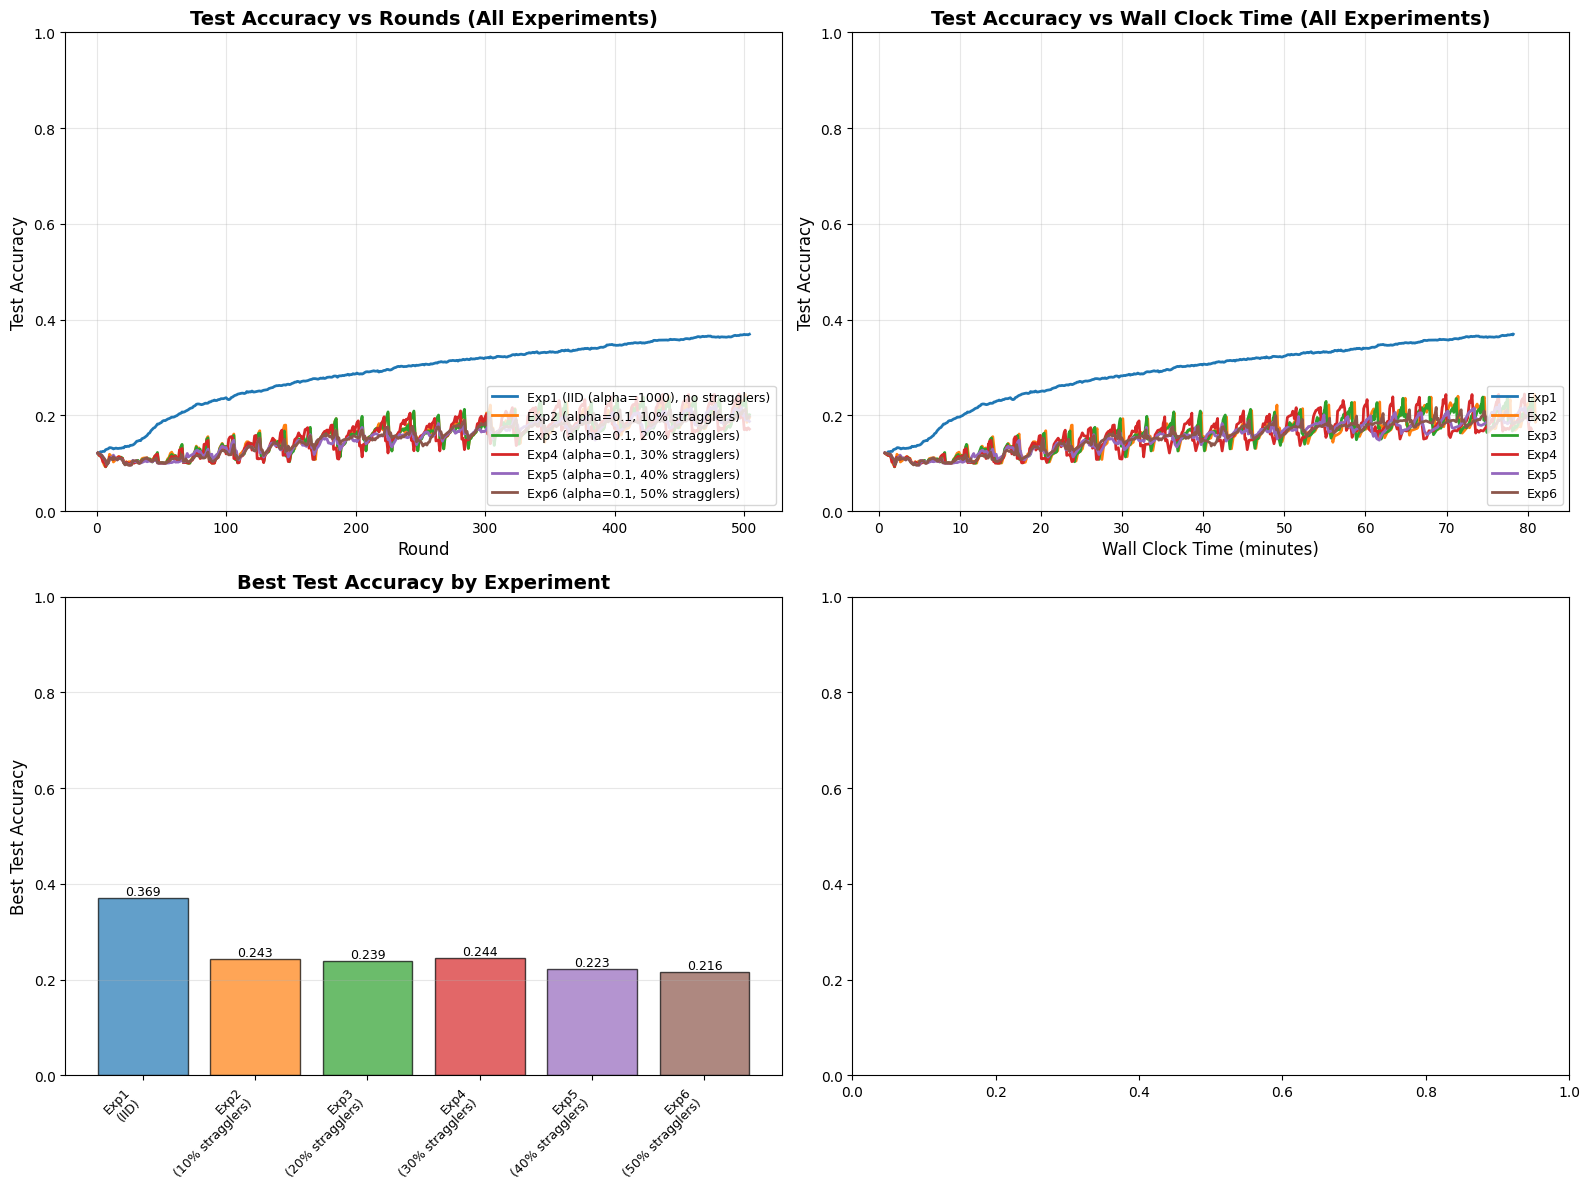


EXPERIMENT COMPARISON SUMMARY
Exp    Alpha    Stragglers   Best Acc   Final Acc   Time (min)  
--------------------------------------------------------------------------------
Exp1   1000.0   0            0.3694     0.3694      78.23       
Exp2   0.1      10           0.2434     0.1946      81.09       
Exp3   0.1      20           0.2386     0.2010      80.82       
Exp4   0.1      30           0.2443     0.1712      80.45       
Exp5   0.1      40           0.2226     0.1872      80.22       
Exp6   0.1      50           0.2164     0.1978      80.69       


In [83]:
# Compare all experiments (load results from experiment_results)
if 'experiment_results' in globals() and len(experiment_results) > 0:
    # Load all CSV files
    all_data = {}
    for exp_id, result in experiment_results.items():
        if result.get("status") == "completed":
            csv_path = result["run_dir"] / "TrustWeight.csv"
            if csv_path.exists():
                df = pd.read_csv(csv_path)
                df['time_min'] = df['time'] / 60.0
                all_data[exp_id] = df
                print(f"✅ Loaded {exp_id}: {len(df)} rows")

    if len(all_data) > 0:
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

        # Plot 1: Accuracy vs Rounds
        for i, (exp_id, df) in enumerate(all_data.items()):
            axes[0, 0].plot(df['total_agg'], df['test_acc'],
                          label=f"{exp_id} ({experiments[exp_id]['name']})",
                          linewidth=2, color=colors[i % len(colors)])
        axes[0, 0].set_xlabel('Round', fontsize=12)
        axes[0, 0].set_ylabel('Test Accuracy', fontsize=12)
        axes[0, 0].set_title('Test Accuracy vs Rounds (All Experiments)', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=9, loc='lower right')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1.0])

        # Plot 2: Accuracy vs Wall Clock Time
        for i, (exp_id, df) in enumerate(all_data.items()):
            axes[0, 1].plot(df['time_min'], df['test_acc'],
                          label=f"{exp_id}",
                          linewidth=2, color=colors[i % len(colors)])
        axes[0, 1].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
        axes[0, 1].set_ylabel('Test Accuracy', fontsize=12)
        axes[0, 1].set_title('Test Accuracy vs Wall Clock Time (All Experiments)', fontsize=14, fontweight='bold')
        axes[0, 1].legend(fontsize=9, loc='lower right')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim([0, 1.0])

        # Plot 3: Best Accuracy by Experiment
        best_accs = {exp_id: df['test_acc'].max() for exp_id, df in all_data.items()}
        exp_names = [f"{exp_id}\n({experiments[exp_id]['clients']['struggle_percent']}% stragglers)"
                    if exp_id != 'Exp1' else f"{exp_id}\n(IID)"
                    for exp_id in best_accs.keys()]
        axes[1, 0].bar(range(len(best_accs)), list(best_accs.values()),
                      color=colors[:len(best_accs)], alpha=0.7, edgecolor='black')
        axes[1, 0].set_xticks(range(len(best_accs)))
        axes[1, 0].set_xticklabels(exp_names, fontsize=9, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Best Test Accuracy', fontsize=12)
        axes[1, 0].set_title('Best Test Accuracy by Experiment', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        axes[1, 0].set_ylim([0, 1.0])
        # Add value labels
        for i, (exp_id, acc) in enumerate(best_accs.items()):
            axes[1, 0].text(i, acc, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        # Plot 4: Time to reach 50% accuracy
        times_to_50 = {}
        for exp_id, df in all_data.items():
            mask = df['test_acc'] >= 0.5
            if mask.any():
                first_idx = mask.idxmax()
                times_to_50[exp_id] = df.loc[first_idx, 'time_min']
            else:
                times_to_50[exp_id] = None

        valid_times = {k: v for k, v in times_to_50.items() if v is not None}
        if len(valid_times) > 0:
            exp_names_50 = [f"{exp_id}\n({experiments[exp_id]['clients']['struggle_percent']}% stragglers)"
                           if exp_id != 'Exp1' else f"{exp_id}\n(IID)"
                           for exp_id in valid_times.keys()]
            axes[1, 1].bar(range(len(valid_times)), list(valid_times.values()),
                         color=colors[:len(valid_times)], alpha=0.7, edgecolor='black')
            axes[1, 1].set_xticks(range(len(valid_times)))
            axes[1, 1].set_xticklabels(exp_names_50, fontsize=9, rotation=45, ha='right')
            axes[1, 1].set_ylabel('Time to Reach 50% Accuracy (minutes)', fontsize=12)
            axes[1, 1].set_title('Convergence Speed: Time to 50% Accuracy', fontsize=14, fontweight='bold')
            axes[1, 1].grid(True, alpha=0.3, axis='y')
            # Add value labels
            for i, (exp_id, t) in enumerate(valid_times.items()):
                axes[1, 1].text(i, t, f'{t:.1f}m', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        # Use Google Drive path if in Colab, otherwise local
        if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
            comparison_dir = BASE_OUTPUT_DIR / "logs" / "TrustWeight" / "comparisons"
        else:
            comparison_dir = Path("./logs/TrustWeight/comparisons")
        comparison_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(comparison_dir / "all_experiments_comparison.png", dpi=150, bbox_inches='tight')
        print(f"\n✅ Comparison plot saved: {comparison_dir / 'all_experiments_comparison.png'}")
        plt.show()

        # Print summary table
        print("\n" + "="*80)
        print("EXPERIMENT COMPARISON SUMMARY")
        print("="*80)
        print(f"{'Exp':<6} {'Alpha':<8} {'Stragglers':<12} {'Best Acc':<10} {'Final Acc':<11} {'Time (min)':<12}")
        print("-"*80)
        for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
            if exp_id in all_data:
                df = all_data[exp_id]
                cfg = experiments[exp_id]
                print(f"{exp_id:<6} {cfg['partition_alpha']:<8.1f} {cfg['clients']['struggle_percent']:<12} "
                      f"{df['test_acc'].max():<10.4f} {df['test_acc'].iloc[-1]:<11.4f} "
                      f"{df['time_min'].iloc[-1]:<12.2f}")
        print("="*80)
    else:
        print("⚠️  No completed experiments found. Run experiments first.")
else:
    print("⚠️  No experiment results found. Run the experiments first using Section 8.")




## 10. View Results


In [84]:
# Load and display results for all 6 experiments
if 'experiment_results' in globals() and len(experiment_results) > 0:
    print("="*80)
    print("TRUSTWEIGHT RESULTS - ALL 6 EXPERIMENTS")
    print("="*80)

    all_results = {}

    for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
        if exp_id in experiment_results and experiment_results[exp_id].get("status") == "completed":
            run_dir = experiment_results[exp_id]["run_dir"]
            csv_path = run_dir / "TrustWeight.csv"

            if csv_path.exists():
                df = pd.read_csv(csv_path)
                all_results[exp_id] = df

                exp_config = experiments[exp_id]
                print(f"\n{'='*80}")
                print(f"{exp_id}: {exp_config['name']}")
                print(f"{'='*80}")
                print(f"  Alpha: {exp_config['partition_alpha']}")
                print(f"  Stragglers: {exp_config['clients']['struggle_percent']}%")
                print(f"  Max rounds: {exp_config['train']['max_rounds']}")
                print(f"\n  Total rounds completed: {df['total_agg'].max()}")

                final_row = df.iloc[-1]
                print(f"\n  Final metrics:")
                print(f"    - Test accuracy: {final_row['test_acc']:.4f}")
                print(f"    - Train accuracy: {final_row['avg_train_acc']:.4f}")
                print(f"    - Test loss: {final_row['test_loss']:.4f}")
                print(f"    - Total time: {final_row['time']:.1f} seconds ({final_row['time']/60:.2f} minutes)")

                best_acc = df['test_acc'].max()
                best_round = df.loc[df['test_acc'].idxmax(), 'total_agg']
                print(f"\n  Best test accuracy: {best_acc:.4f} (round {best_round})")

                print(f"\n  Run folder: {run_dir}")
            else:
                print(f"\n{'='*80}")
                print(f"{exp_id}: Results file not found")
                print(f"  Run folder: {run_dir}")
        else:
            status = experiment_results.get(exp_id, {}).get("status", "not run")
            print(f"\n{'='*80}")
            print(f"{exp_id}: {status.upper()}")
            if status == "error":
                print(f"  Error: {experiment_results[exp_id].get('error', 'Unknown error')}")

    # Summary table
    if len(all_results) > 0:
        print(f"\n{'='*80}")
        print("SUMMARY TABLE")
        print("="*80)
        print(f"{'Exp':<6} {'Alpha':<8} {'Stragglers':<12} {'Rounds':<8} {'Best Acc':<10} {'Final Acc':<11} {'Time (min)':<12}")
        print("-"*80)

        for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
            if exp_id in all_results:
                df = all_results[exp_id]
                cfg = experiments[exp_id]
                final_row = df.iloc[-1]
                print(f"{exp_id:<6} {cfg['partition_alpha']:<8.1f} {cfg['clients']['struggle_percent']:<12} "
                      f"{df['total_agg'].max():<8} {df['test_acc'].max():<10.4f} {final_row['test_acc']:<11.4f} "
                      f"{final_row['time']/60:<12.2f}")

        print("="*80)

        # Show first and last rows for each experiment
        print(f"\n{'='*80}")
        print("DETAILED DATA PREVIEW")
        print("="*80)

        for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
            if exp_id in all_results:
                df = all_results[exp_id]
                exp_config = experiments[exp_id]
                print(f"\n{exp_id}: {exp_config['name']}")
                print(f"  First 3 rows:")
                print(df.head(3).to_string(index=False))
                print(f"\n  Last 3 rows:")
                print(df.tail(3).to_string(index=False))
                print()
    else:
        print("\n⚠️  No completed experiments found. Run experiments first using Section 8.")
else:
    print("⚠️  No experiment results found. Run experiments first using Section 8.")
    print("   The 'experiment_results' dictionary will be created after running Section 8.")




TRUSTWEIGHT RESULTS - ALL 6 EXPERIMENTS

Exp1: IID (alpha=1000), no stragglers
  Alpha: 1000.0
  Stragglers: 0%
  Max rounds: 500

  Total rounds completed: 504

  Final metrics:
    - Test accuracy: 0.3694
    - Train accuracy: 0.3300
    - Test loss: 1.6867
    - Total time: 4694.0 seconds (78.23 minutes)

  Best test accuracy: 0.3694 (round 504)

  Run folder: /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp1/run_20251130_110604

Exp2: alpha=0.1, 10% stragglers
  Alpha: 0.1
  Stragglers: 10%
  Max rounds: 500

  Total rounds completed: 504

  Final metrics:
    - Test accuracy: 0.1946
    - Train accuracy: 0.8009
    - Test loss: 2.1515
    - Total time: 4865.2 seconds (81.09 minutes)

  Best test accuracy: 0.2434 (round 501)

  Run folder: /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp2/run_20251130_122421

Exp3: alpha=0.1, 20% stragglers
  Alpha: 0.1
  Stragglers: 20%
  Max rounds: 500

  Total rounds completed: 504

  Final metrics:
    - Test accuracy

## 11. Comprehensive Results Visualization


In [85]:
# Comprehensive visualization suite for all 6 experiments
if 'experiment_results' in globals() and len(experiment_results) > 0:
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    all_data = {}
    all_participation = {}

    # Load all experiment data
    for exp_id in ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6"]:
        if exp_id in experiment_results and experiment_results[exp_id].get("status") == "completed":
            run_dir = experiment_results[exp_id]["run_dir"]
            csv_path = run_dir / "TrustWeight.csv"
            participation_path = run_dir / "TrustWeightClientParticipation.csv"

            if csv_path.exists():
                df = pd.read_csv(csv_path)
                df['time_min'] = df['time'] / 60.0
                all_data[exp_id] = {
                    'df': df,
                    'run_dir': run_dir,
                    'config': experiments[exp_id]
                }

                if participation_path.exists():
                    part_df = pd.read_csv(participation_path)
                    all_participation[exp_id] = part_df

    if len(all_data) > 0:
        print(f"✅ Loaded data for {len(all_data)} experiments")
        print("="*80)

        # Generate individual plots for each experiment
        for exp_id, exp_data in all_data.items():
            df = exp_data['df']
            run_dir = exp_data['run_dir']
            exp_config = exp_data['config']
            participation_path = run_dir / "TrustWeightClientParticipation.csv"

            print(f"\n📊 Generating plots for {exp_id}: {exp_config['name']}")

            # Plot 1: Accuracy vs Rounds
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            axes[0].plot(df['total_agg'], df['test_acc'], label='Test Accuracy', marker='o', markersize=4, linewidth=2)
            train_acc = df[df['avg_train_acc'] > 0]['avg_train_acc']
            train_rounds = df[df['avg_train_acc'] > 0]['total_agg']
            if len(train_acc) > 0:
                axes[0].plot(train_rounds, train_acc, label='Train Accuracy', marker='s', markersize=4, linewidth=2, color='orange')
            axes[0].set_xlabel('Round', fontsize=12)
            axes[0].set_ylabel('Accuracy', fontsize=12)
            axes[0].set_title(f'{exp_id}: Accuracy vs Rounds', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=10)
            axes[0].set_ylim([0, 1.0])

            axes[1].plot(df['total_agg'], df['test_loss'], label='Test Loss', marker='o', markersize=4, linewidth=2, color='red')
            train_loss = df[df['avg_train_loss'] > 0]['avg_train_loss']
            train_rounds_loss = df[df['avg_train_loss'] > 0]['total_agg']
            if len(train_loss) > 0:
                axes[1].plot(train_rounds_loss, train_loss, label='Train Loss', marker='s', markersize=4, linewidth=2, color='purple')
            axes[1].set_xlabel('Round', fontsize=12)
            axes[1].set_ylabel('Loss', fontsize=12)
            axes[1].set_title(f'{exp_id}: Loss vs Rounds', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=10)

            plt.tight_layout()
            plt.savefig(run_dir / "1_accuracy_loss_vs_rounds.png", dpi=150, bbox_inches='tight')
            plt.close()

            # Plot 2: Accuracy vs Wall Clock Time
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            axes[0].plot(df['time_min'], df['test_acc'], label='Test Accuracy', marker='o', markersize=4, linewidth=2)
            train_acc_time = df[df['avg_train_acc'] > 0]['avg_train_acc']
            train_time = df[df['avg_train_acc'] > 0]['time_min']
            if len(train_acc_time) > 0:
                axes[0].plot(train_time, train_acc_time, label='Train Accuracy', marker='s', markersize=4, linewidth=2, color='orange')
            axes[0].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
            axes[0].set_ylabel('Accuracy', fontsize=12)
            axes[0].set_title(f'{exp_id}: Accuracy vs Wall Clock Time', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=10)
            axes[0].set_ylim([0, 1.0])

            axes[1].plot(df['time_min'], df['test_loss'], label='Test Loss', marker='o', markersize=4, linewidth=2, color='red')
            train_loss_time = df[df['avg_train_loss'] > 0]['avg_train_loss']
            train_time_loss = df[df['avg_train_loss'] > 0]['time_min']
            if len(train_loss_time) > 0:
                axes[1].plot(train_time_loss, train_loss_time, label='Train Loss', marker='s', markersize=4, linewidth=2, color='purple')
            axes[1].set_xlabel('Wall Clock Time (minutes)', fontsize=12)
            axes[1].set_ylabel('Loss', fontsize=12)
            axes[1].set_title(f'{exp_id}: Loss vs Wall Clock Time', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=10)

            plt.tight_layout()
            plt.savefig(run_dir / "2_accuracy_loss_vs_time.png", dpi=150, bbox_inches='tight')
            plt.close()

            # Plot 3: Convergence Speed Analysis
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
            times_to_threshold = []
            rounds_to_threshold = []
            reached_thresholds = []

            for thresh in thresholds:
                mask = df['test_acc'] >= thresh
                if mask.any():
                    first_idx = mask.idxmax()
                    times_to_threshold.append(df.loc[first_idx, 'time_min'])
                    rounds_to_threshold.append(df.loc[first_idx, 'total_agg'])
                    reached_thresholds.append(thresh)
                else:
                    break

            if len(reached_thresholds) > 0:
                axes[0].bar(range(len(reached_thresholds)), times_to_threshold, color='skyblue', alpha=0.7, edgecolor='navy')
                axes[0].set_xlabel('Accuracy Threshold', fontsize=12)
                axes[0].set_ylabel('Time to Reach (minutes)', fontsize=12)
                axes[0].set_title(f'{exp_id}: Time to Reach Accuracy Thresholds', fontsize=14, fontweight='bold')
                axes[0].set_xticks(range(len(reached_thresholds)))
                axes[0].set_xticklabels([f'{t:.1f}' for t in reached_thresholds], fontsize=10)
                axes[0].grid(True, alpha=0.3, axis='y')

                for i, (t, v) in enumerate(zip(reached_thresholds, times_to_threshold)):
                    axes[0].text(i, v, f'{v:.1f}m', ha='center', va='bottom', fontsize=9)

                axes[1].bar(range(len(reached_thresholds)), rounds_to_threshold, color='lightcoral', alpha=0.7, edgecolor='darkred')
                axes[1].set_xlabel('Accuracy Threshold', fontsize=12)
                axes[1].set_ylabel('Rounds to Reach', fontsize=12)
                axes[1].set_title(f'{exp_id}: Rounds to Reach Accuracy Thresholds', fontsize=14, fontweight='bold')
                axes[1].set_xticks(range(len(reached_thresholds)))
                axes[1].set_xticklabels([f'{t:.1f}' for t in reached_thresholds], fontsize=10)
                axes[1].grid(True, alpha=0.3, axis='y')

                for i, (t, v) in enumerate(zip(reached_thresholds, rounds_to_threshold)):
                    axes[1].text(i, v, f'{int(v)}', ha='center', va='bottom', fontsize=9)

            plt.tight_layout()
            plt.savefig(run_dir / "3_convergence_speed.png", dpi=150, bbox_inches='tight')
            plt.close()

            # Plot 4: Training Efficiency
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            if len(df) > 1:
                df_sorted = df.sort_values('time_min')
                efficiency = df_sorted['test_acc'].diff() / df_sorted['time_min'].diff()
                efficiency = efficiency.fillna(0)

                ax.plot(df_sorted['time_min'], efficiency, marker='o', markersize=3, linewidth=2, color='green')
                ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
                ax.set_xlabel('Wall Clock Time (minutes)', fontsize=12)
                ax.set_ylabel('Accuracy Gain per Minute', fontsize=12)
                ax.set_title(f'{exp_id}: Training Efficiency', fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3)

                max_eff_idx = efficiency.idxmax()
                max_eff_time = df_sorted.loc[max_eff_idx, 'time_min']
                max_eff_val = efficiency.loc[max_eff_idx]
                ax.plot(max_eff_time, max_eff_val, 'r*', markersize=15, label=f'Peak: {max_eff_val:.4f}/min')
                ax.legend(fontsize=10)

            plt.tight_layout()
            plt.savefig(run_dir / "4_training_efficiency.png", dpi=150, bbox_inches='tight')
            plt.close()

            # Plot 5: Client Participation Analysis
            if participation_path.exists():
                part_df = pd.read_csv(participation_path)

                fig, axes = plt.subplots(2, 2, figsize=(14, 10))

                client_counts = part_df['client_id'].value_counts().sort_index()
                axes[0, 0].bar(client_counts.index, client_counts.values, color='steelblue', alpha=0.7, edgecolor='navy')
                axes[0, 0].set_xlabel('Client ID', fontsize=11)
                axes[0, 0].set_ylabel('Number of Updates', fontsize=11)
                axes[0, 0].set_title(f'{exp_id}: Client Participation Frequency', fontsize=12, fontweight='bold')
                axes[0, 0].grid(True, alpha=0.3, axis='y')

                participation_by_round = part_df.groupby('total_agg')['client_id'].count()
                axes[0, 1].plot(participation_by_round.index, participation_by_round.values,
                               marker='o', markersize=4, linewidth=2, color='coral')
                axes[0, 1].set_xlabel('Round', fontsize=11)
                axes[0, 1].set_ylabel('Number of Clients', fontsize=11)
                axes[0, 1].set_title(f'{exp_id}: Client Participation per Round', fontsize=12, fontweight='bold')
                axes[0, 1].grid(True, alpha=0.3)

                client_acc_by_round = part_df.groupby('total_agg')['local_test_acc'].mean()
                axes[1, 0].plot(client_acc_by_round.index, client_acc_by_round.values,
                                marker='s', markersize=4, linewidth=2, color='mediumseagreen')
                axes[1, 0].set_xlabel('Round', fontsize=11)
                axes[1, 0].set_ylabel('Average Client Test Accuracy', fontsize=11)
                axes[1, 0].set_title(f'{exp_id}: Average Client Accuracy Over Rounds', fontsize=12, fontweight='bold')
                axes[1, 0].grid(True, alpha=0.3)
                axes[1, 0].set_ylim([0, 1.0])

                if len(part_df) > 0:
                    client_accs = [part_df[part_df['client_id'] == cid]['local_test_acc'].values
                                  for cid in sorted(part_df['client_id'].unique())[:10]]
                    if len(client_accs) > 0:
                        axes[1, 1].boxplot(client_accs, labels=[f'C{i}' for i in range(len(client_accs))])
                        axes[1, 1].set_xlabel('Client ID', fontsize=11)
                        axes[1, 1].set_ylabel('Test Accuracy', fontsize=11)
                        axes[1, 1].set_title(f'{exp_id}: Client Accuracy Distribution', fontsize=12, fontweight='bold')
                        axes[1, 1].grid(True, alpha=0.3, axis='y')
                        axes[1, 1].set_ylim([0, 1.0])

                plt.tight_layout()
                plt.savefig(run_dir / "5_client_participation.png", dpi=150, bbox_inches='tight')
                plt.close()

            # Plot 6: Training Progress Summary
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            axes[0, 0].plot(df['total_agg'], df['test_acc'], 'b-', linewidth=2, label='Test')
            train_acc_plot = df[df['avg_train_acc'] > 0]
            if len(train_acc_plot) > 0:
                axes[0, 0].plot(train_acc_plot['total_agg'], train_acc_plot['avg_train_acc'],
                               'r--', linewidth=2, label='Train')
            axes[0, 0].set_xlabel('Round', fontsize=11)
            axes[0, 0].set_ylabel('Accuracy', fontsize=11)
            axes[0, 0].set_title(f'{exp_id}: Accuracy Trajectory', fontsize=12, fontweight='bold')
            axes[0, 0].legend(fontsize=10)
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].set_ylim([0, 1.0])

            axes[0, 1].plot(df['total_agg'], df['test_loss'], 'b-', linewidth=2, label='Test')
            train_loss_plot = df[df['avg_train_loss'] > 0]
            if len(train_loss_plot) > 0:
                axes[0, 1].plot(train_loss_plot['total_agg'], train_loss_plot['avg_train_loss'],
                               'r--', linewidth=2, label='Train')
            axes[0, 1].set_xlabel('Round', fontsize=11)
            axes[0, 1].set_ylabel('Loss', fontsize=11)
            axes[0, 1].set_title(f'{exp_id}: Loss Trajectory', fontsize=12, fontweight='bold')
            axes[0, 1].legend(fontsize=10)
            axes[0, 1].grid(True, alpha=0.3)

            axes[1, 0].plot(df['time_min'], df['test_acc'], 'b-', linewidth=2, label='Test')
            if len(train_acc_plot) > 0:
                train_time_acc = df[df['avg_train_acc'] > 0]['time_min']
                axes[1, 0].plot(train_time_acc, train_acc_plot['avg_train_acc'],
                                'r--', linewidth=2, label='Train')
            axes[1, 0].set_xlabel('Time (minutes)', fontsize=11)
            axes[1, 0].set_ylabel('Accuracy', fontsize=11)
            axes[1, 0].set_title(f'{exp_id}: Accuracy vs Wall Clock Time', fontsize=12, fontweight='bold')
            axes[1, 0].legend(fontsize=10)
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_ylim([0, 1.0])

            axes[1, 1].plot(df['time_min'], df['total_agg'], 'g-', linewidth=2, marker='o', markersize=3)
            axes[1, 1].set_xlabel('Time (minutes)', fontsize=11)
            axes[1, 1].set_ylabel('Total Rounds', fontsize=11)
            axes[1, 1].set_title(f'{exp_id}: Round Progression Over Time', fontsize=12, fontweight='bold')
            axes[1, 1].grid(True, alpha=0.3)

            if len(df) > 1:
                total_time = df['time_min'].iloc[-1]
                total_rounds = df['total_agg'].iloc[-1]
                rate = total_rounds / total_time if total_time > 0 else 0
                axes[1, 1].text(0.05, 0.95, f'Rate: {rate:.2f} rounds/min',
                               transform=axes[1, 1].transAxes, fontsize=10,
                               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.tight_layout()
            plt.savefig(run_dir / "6_training_summary.png", dpi=150, bbox_inches='tight')
            plt.close()

            print(f"  ✅ All plots saved to {run_dir}")

        # Create comparison plots across all experiments
        print(f"\n📊 Creating comparison plots across all experiments...")

        # Comparison Plot 1: Test Accuracy vs Rounds (all experiments)
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        for i, (exp_id, exp_data) in enumerate(all_data.items()):
            df = exp_data['df']
            exp_config = exp_data['config']
            label = f"{exp_id} (α={exp_config['partition_alpha']}, {exp_config['clients']['struggle_percent']}% stragglers)"
            ax.plot(df['total_agg'], df['test_acc'], label=label, linewidth=2, color=colors[i % len(colors)])
        ax.set_xlabel('Round', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title('Test Accuracy vs Rounds (All Experiments)', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9, loc='lower right')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.0])

        # Save comparison plot
        if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
            comparison_dir = BASE_OUTPUT_DIR / "logs" / "TrustWeight" / "comparisons"
        else:
            comparison_dir = Path("./logs/TrustWeight/comparisons")
        comparison_dir.mkdir(parents=True, exist_ok=True)

        plt.tight_layout()
        plt.savefig(comparison_dir / "comparison_accuracy_vs_rounds.png", dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  ✅ Comparison plot saved: {comparison_dir / 'comparison_accuracy_vs_rounds.png'}")

        # Comparison Plot 2: Test Accuracy vs Time (all experiments)
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        for i, (exp_id, exp_data) in enumerate(all_data.items()):
            df = exp_data['df']
            exp_config = exp_data['config']
            label = f"{exp_id} (α={exp_config['partition_alpha']}, {exp_config['clients']['struggle_percent']}% stragglers)"
            ax.plot(df['time_min'], df['test_acc'], label=label, linewidth=2, color=colors[i % len(colors)])
        ax.set_xlabel('Wall Clock Time (minutes)', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title('Test Accuracy vs Wall Clock Time (All Experiments)', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9, loc='lower right')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.0])

        plt.tight_layout()
        plt.savefig(comparison_dir / "comparison_accuracy_vs_time.png", dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  ✅ Comparison plot saved: {comparison_dir / 'comparison_accuracy_vs_time.png'}")

        print(f"\n✅ All visualizations completed!")
        print(f"   Individual plots saved to each experiment's run folder")
        print(f"   Comparison plots saved to: {comparison_dir}")

    else:
        print("⚠️  No completed experiments found. Run experiments first using Section 8.")
else:
    print("⚠️  No experiment results found. Run experiments first using Section 8.")
    print("   The 'experiment_results' dictionary will be created after running Section 8.")



✅ Loaded data for 6 experiments

📊 Generating plots for Exp1: IID (alpha=1000), no stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp1/run_20251130_110604

📊 Generating plots for Exp2: alpha=0.1, 10% stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp2/run_20251130_122421

📊 Generating plots for Exp3: alpha=0.1, 20% stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp3/run_20251130_134529

📊 Generating plots for Exp4: alpha=0.1, 30% stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp4/run_20251130_150622

📊 Generating plots for Exp5: alpha=0.1, 40% stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp5/run_20251130_162652

📊 Generating plots for Exp6: alpha=0.1, 50% stragglers
  ✅ All plots saved to /content/drive/MyDrive/colab/dml_project/logs/TrustWeight/Exp6/run_202511

Displaying Comparison Plots:

--------------------------------------------------
Test Accuracy vs Rounds (All Experiments)


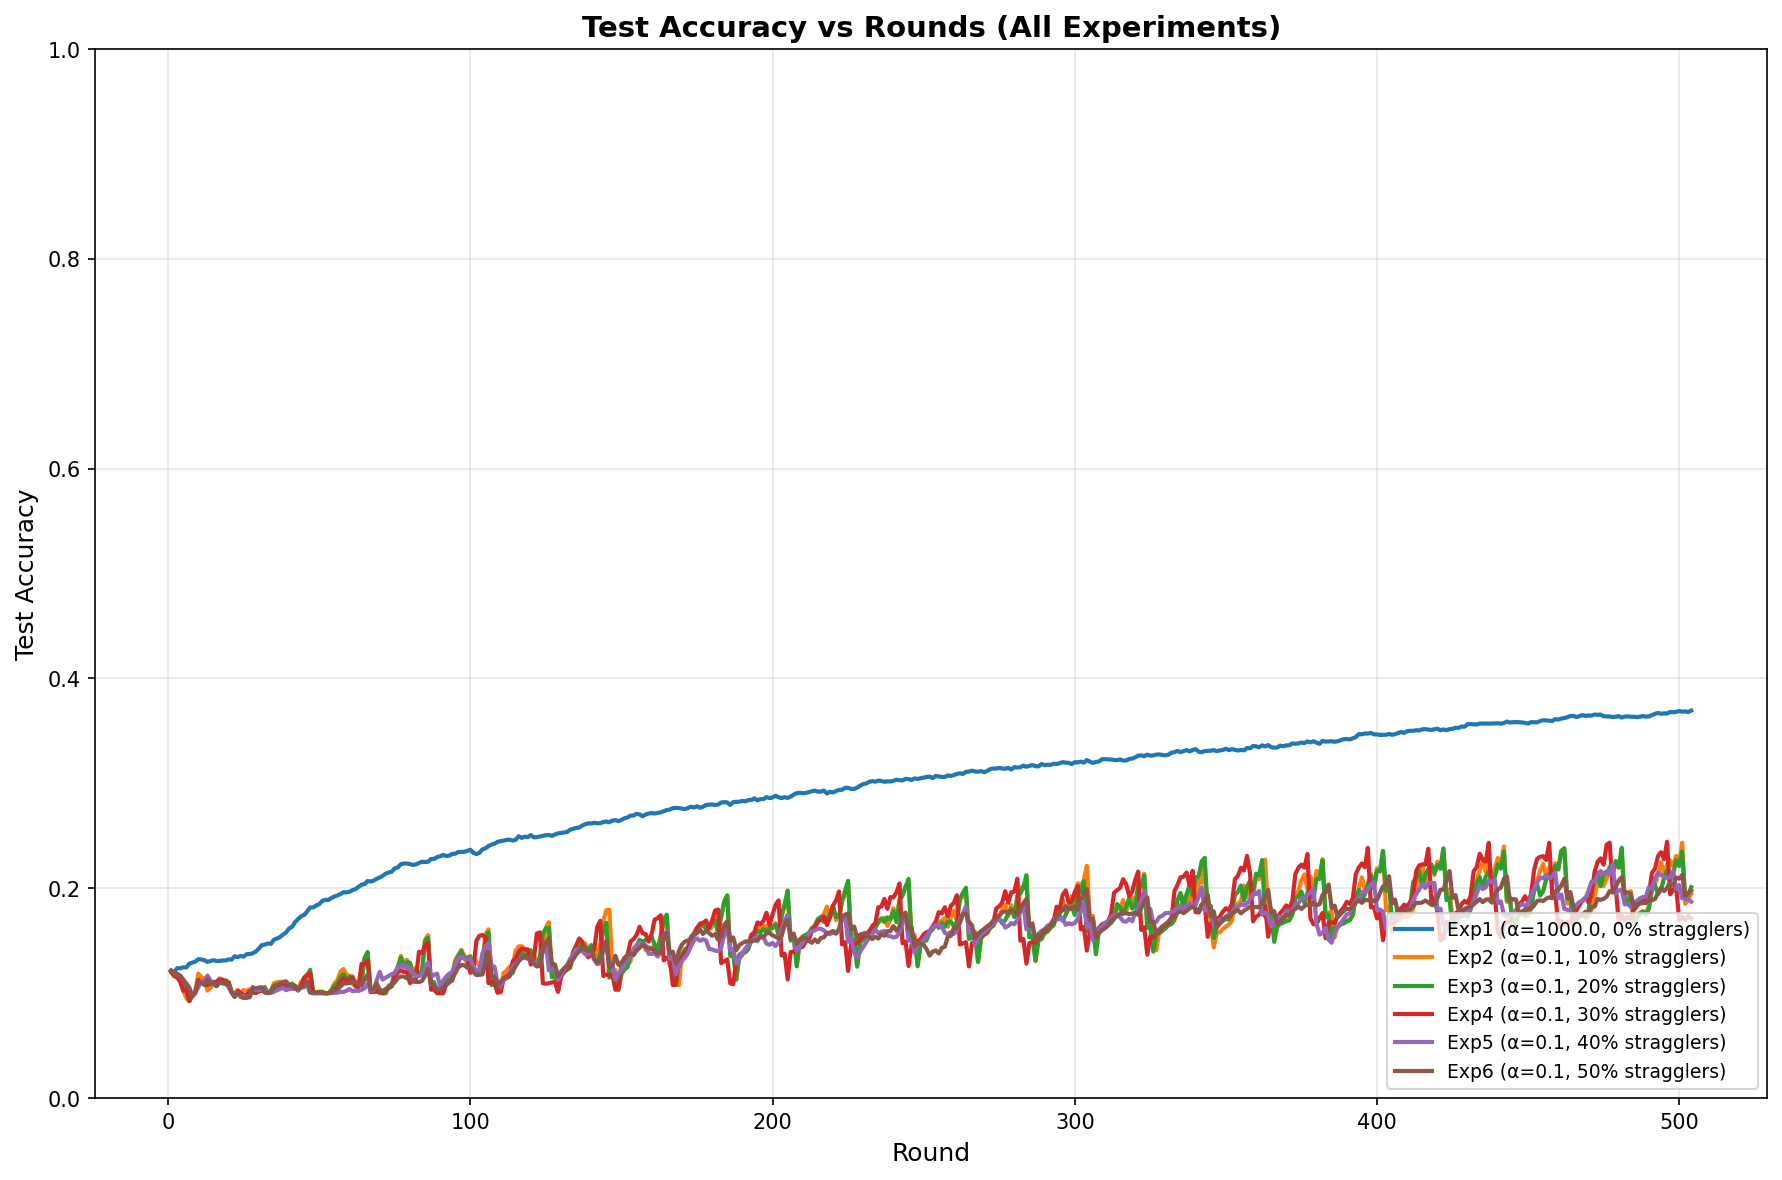


--------------------------------------------------
Test Accuracy vs Wall Clock Time (All Experiments)


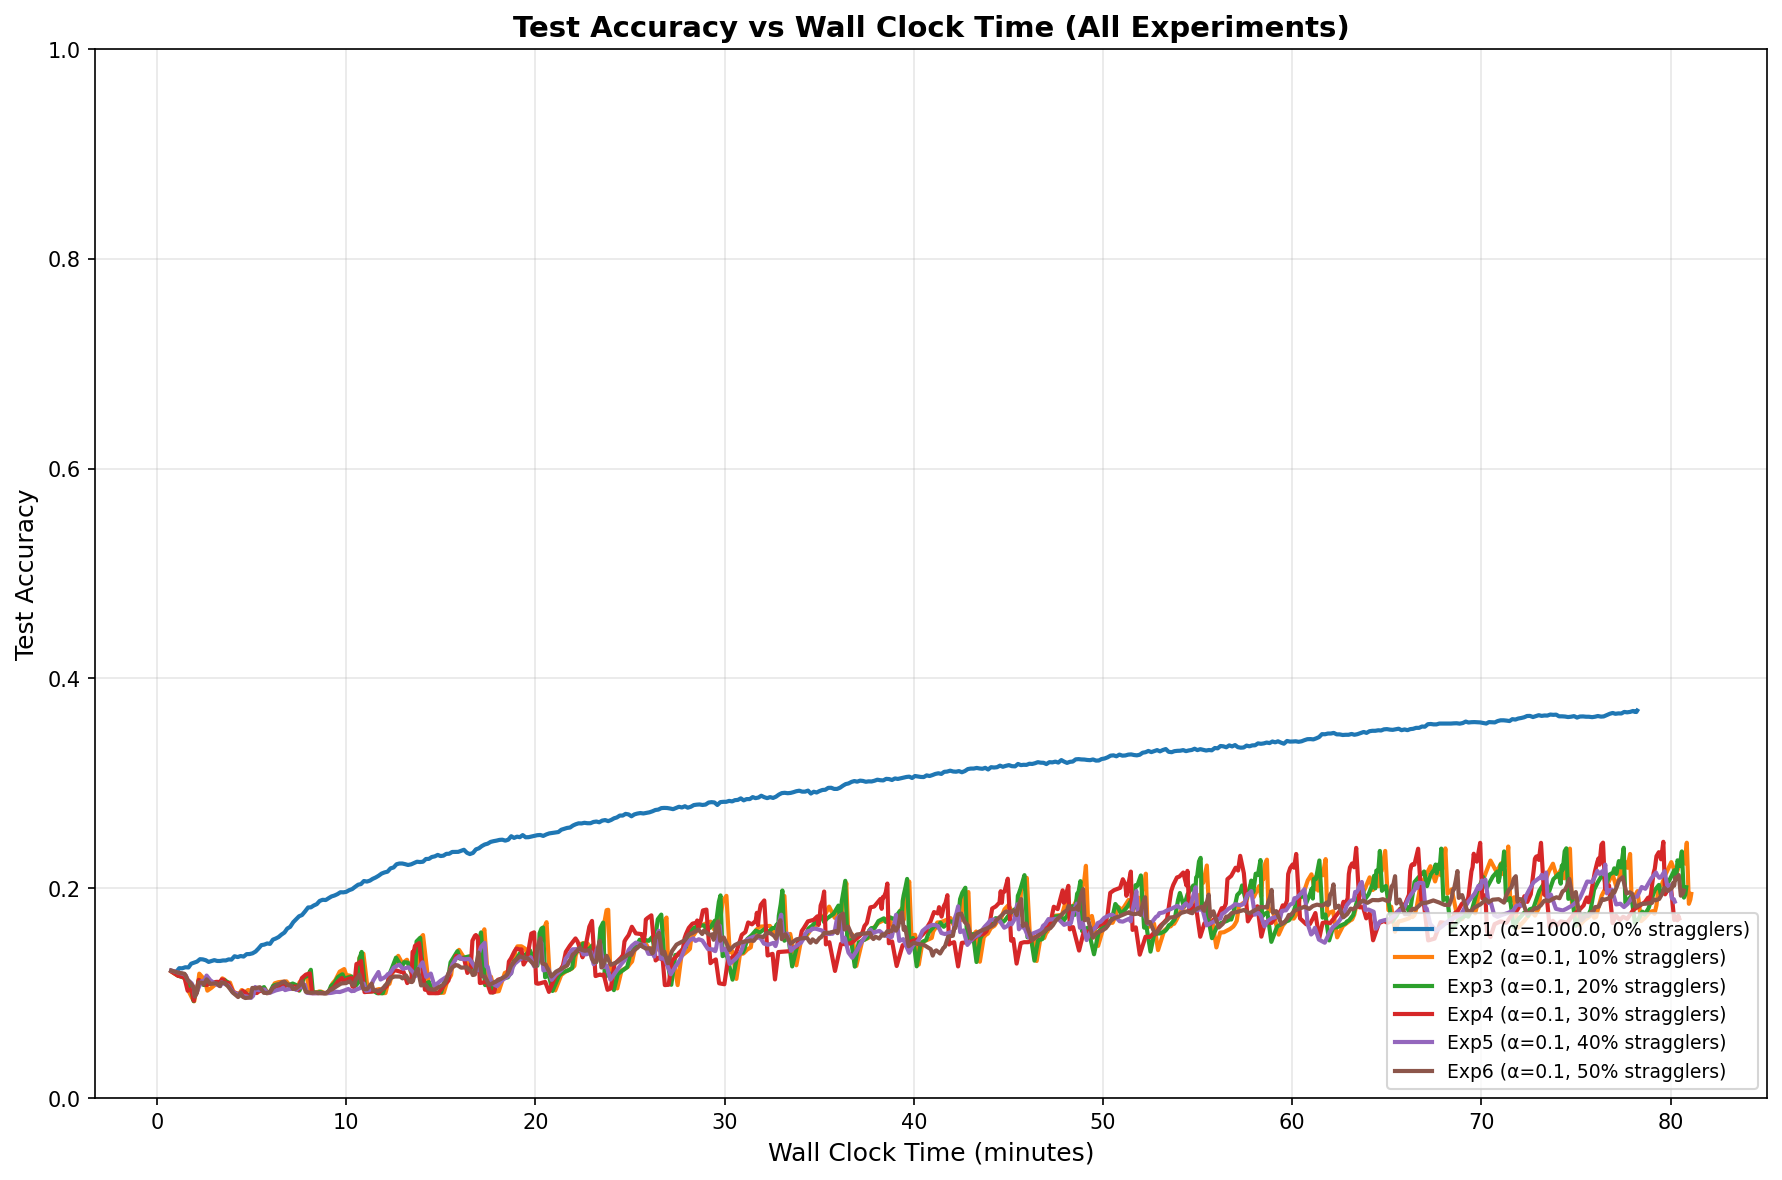


Displaying Individual Experiment Plots (Accuracy vs Rounds):

--------------------------------------------------
Exp1: Accuracy & Loss vs Rounds


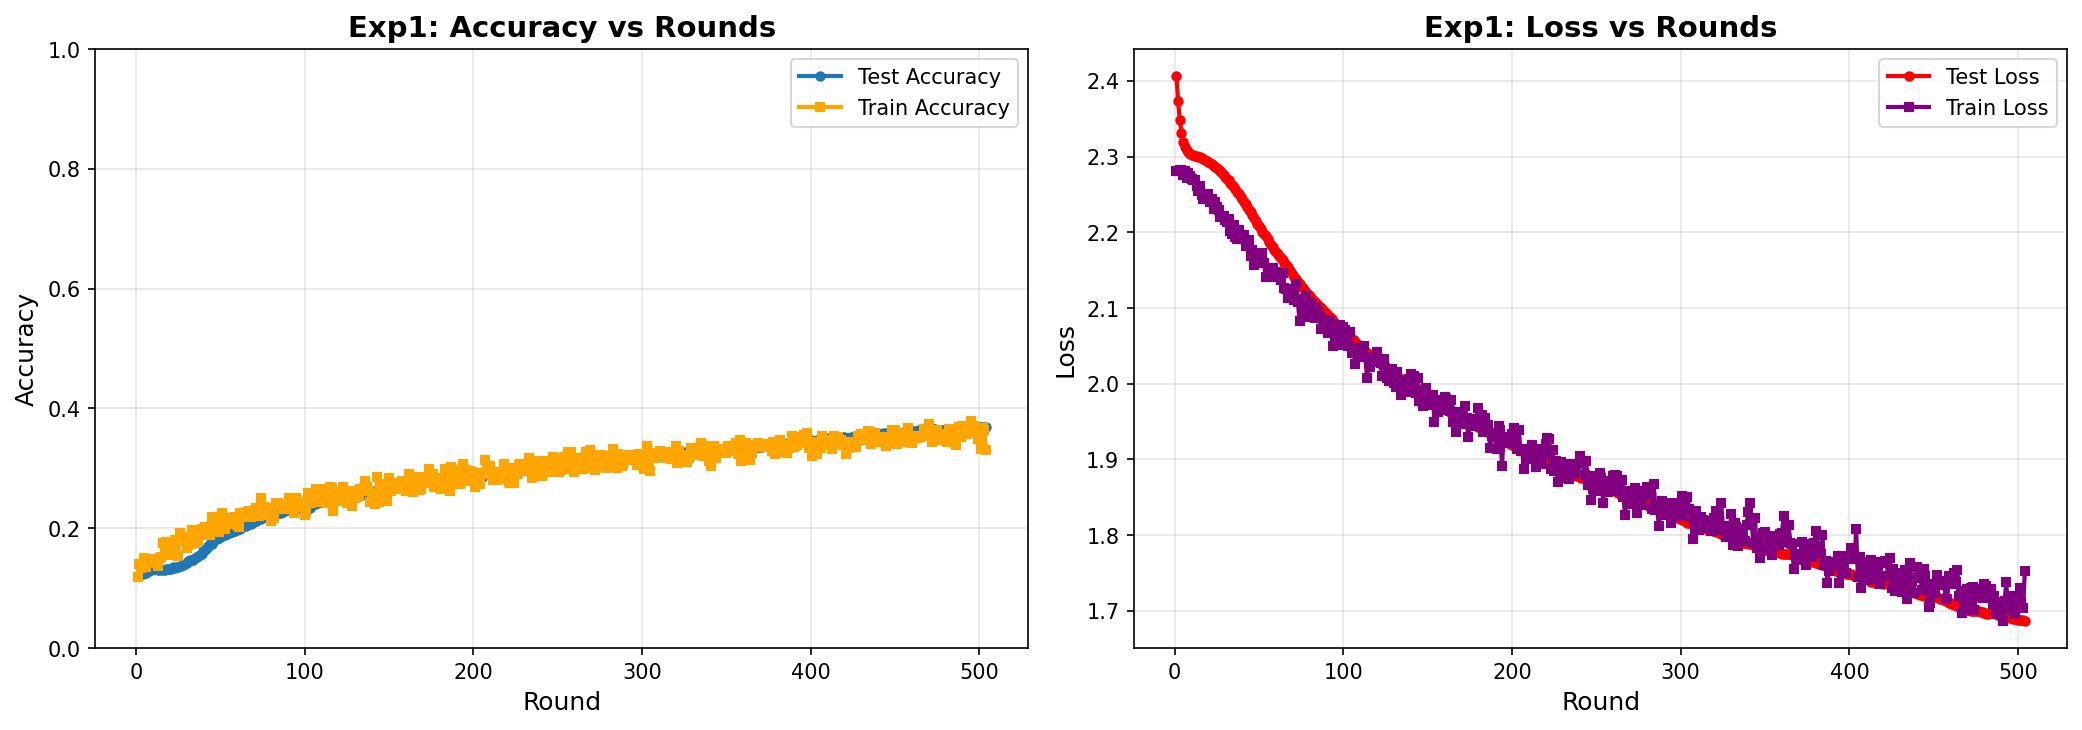


--------------------------------------------------
Exp2: Accuracy & Loss vs Rounds


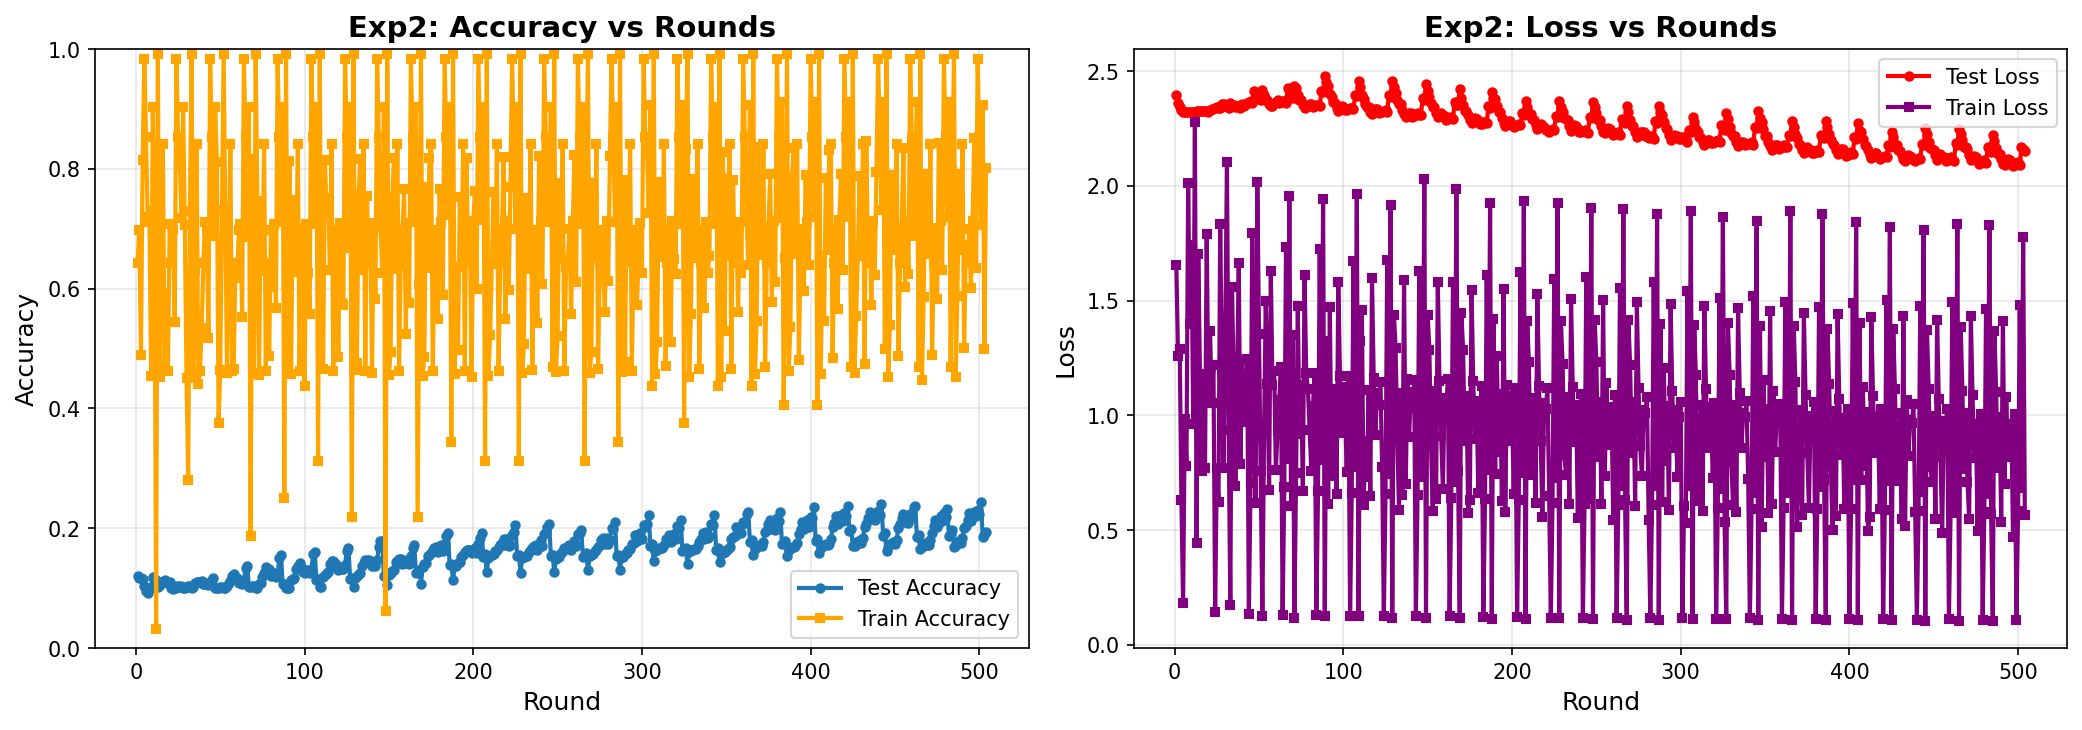


--------------------------------------------------
Exp3: Accuracy & Loss vs Rounds


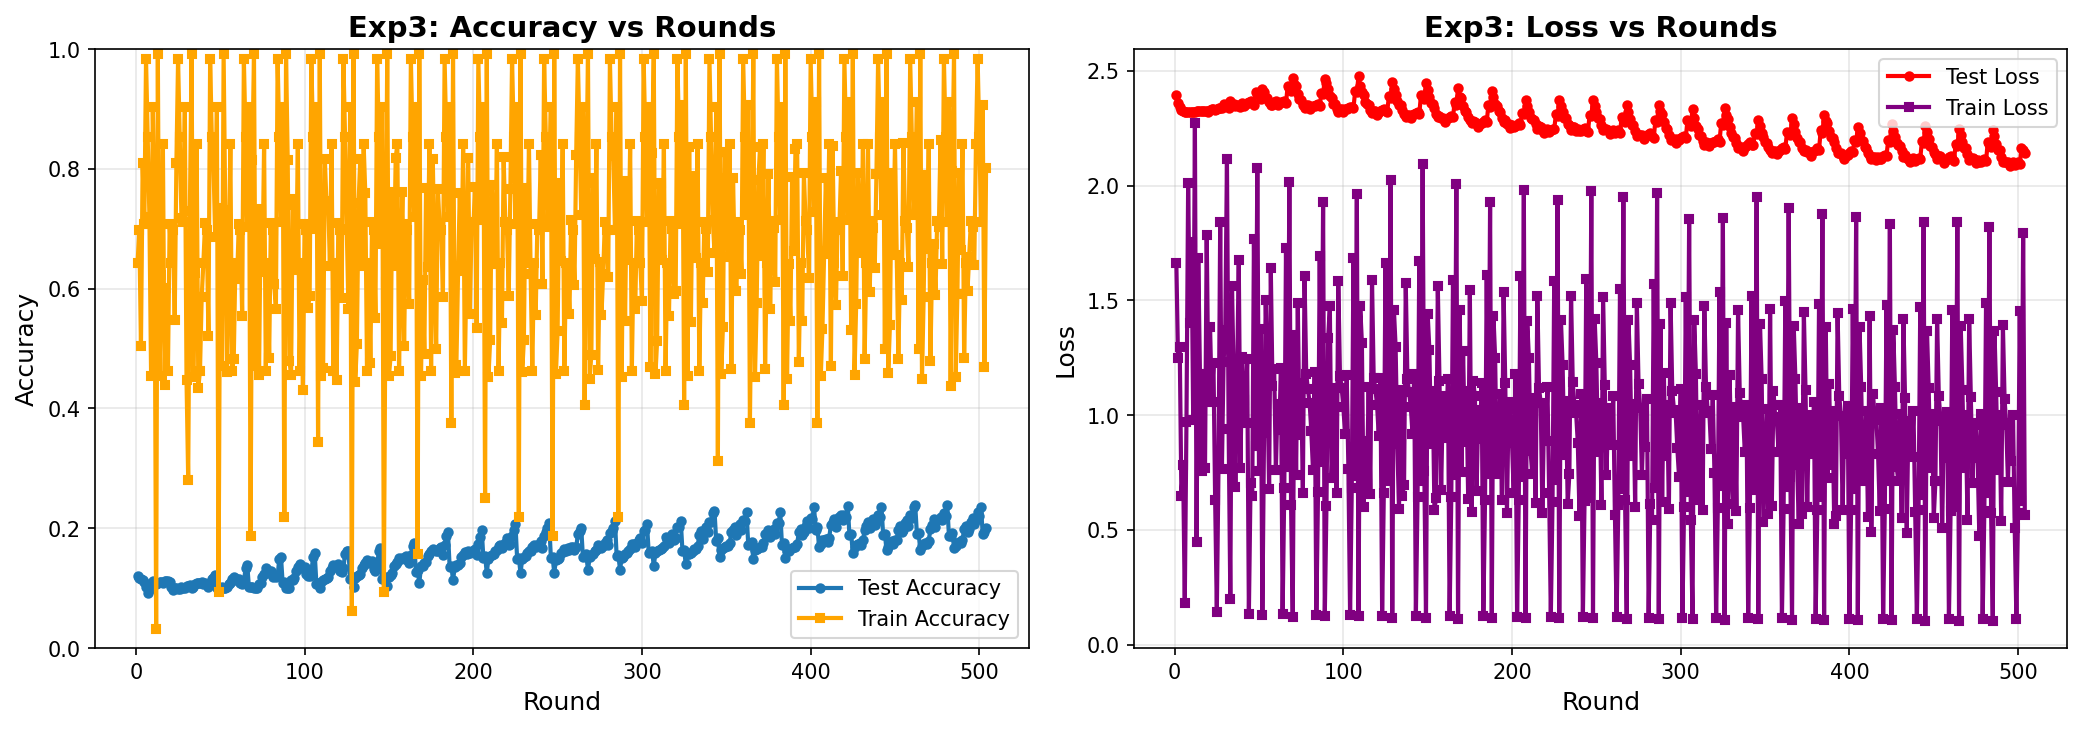


--------------------------------------------------
Exp4: Accuracy & Loss vs Rounds


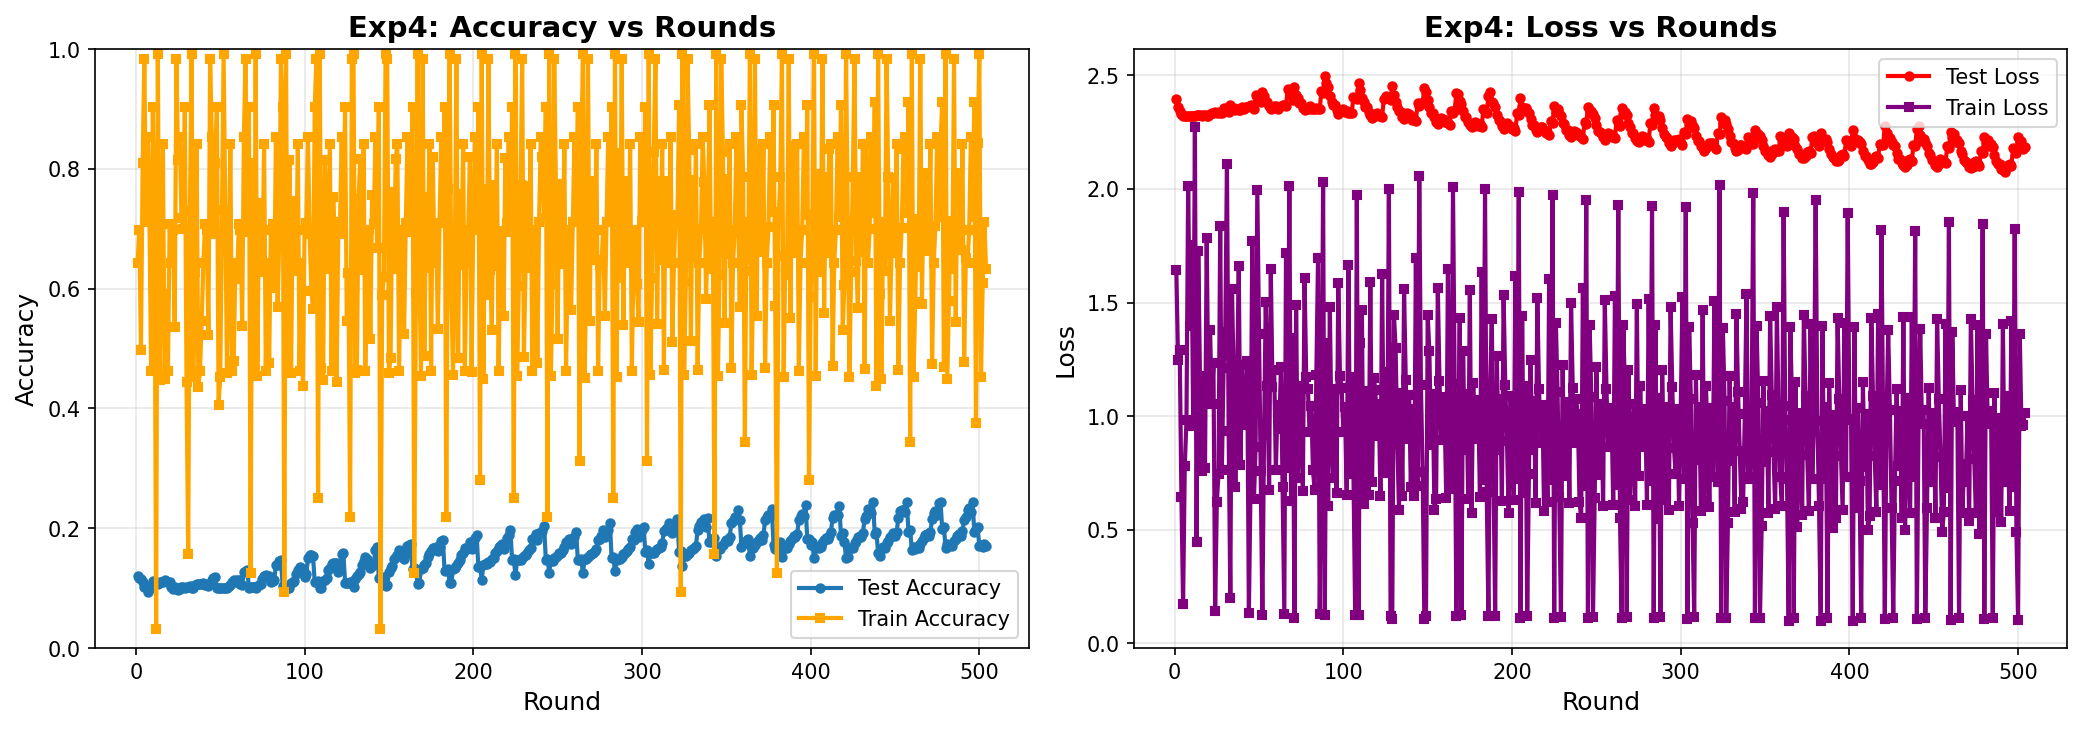


--------------------------------------------------
Exp5: Accuracy & Loss vs Rounds


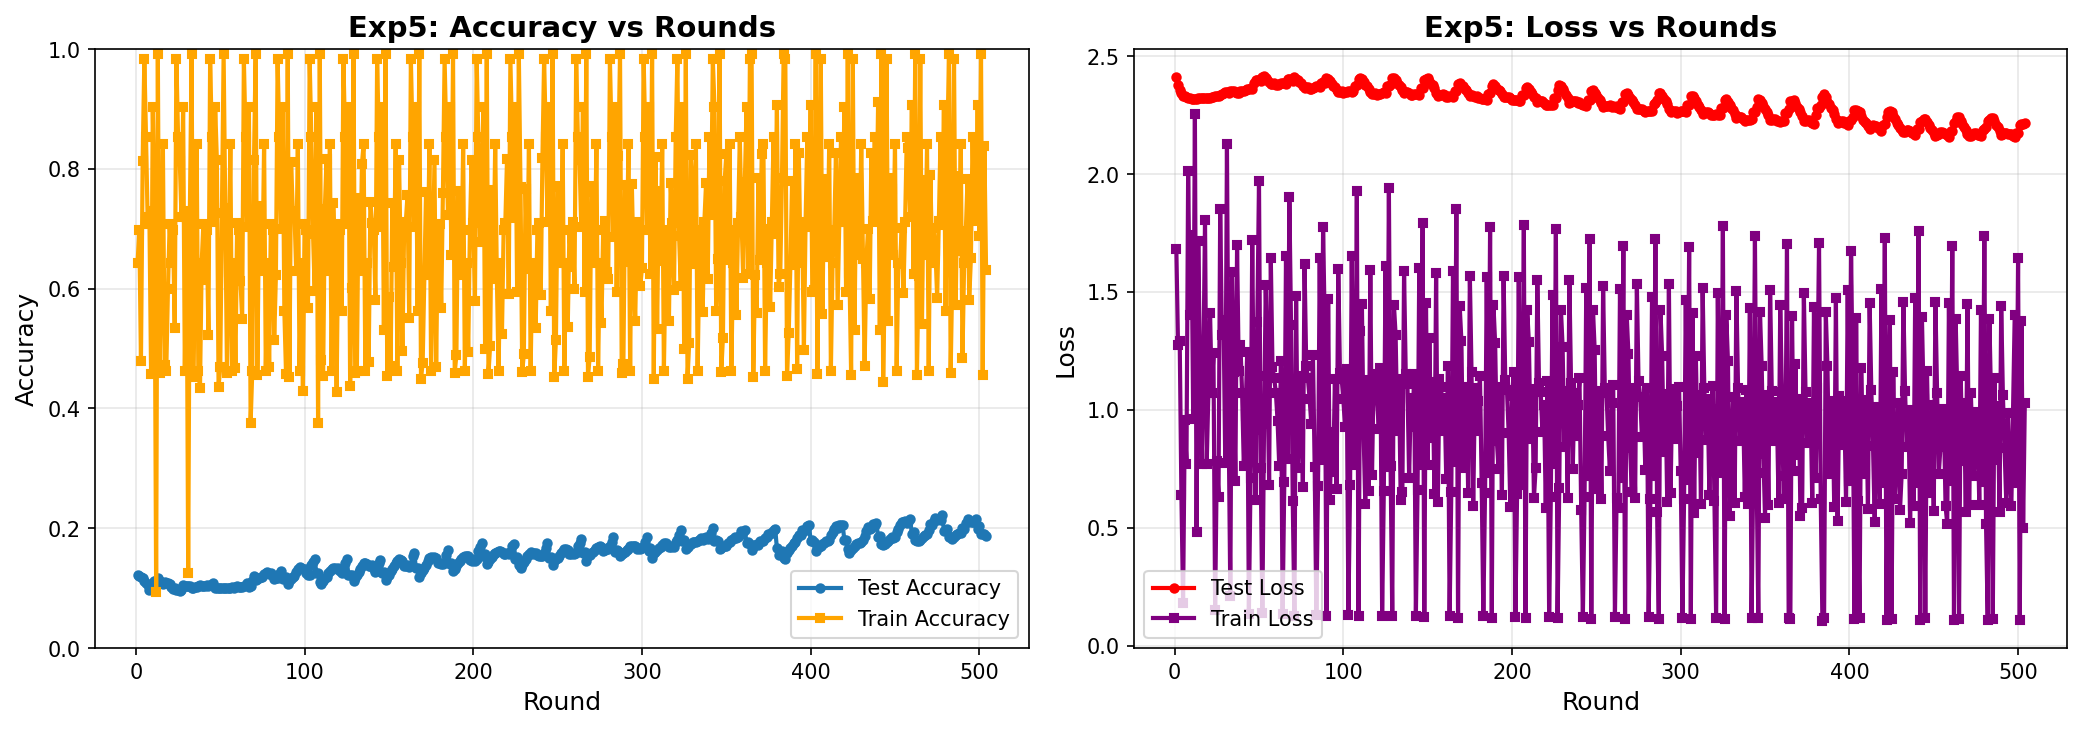


--------------------------------------------------
Exp6: Accuracy & Loss vs Rounds


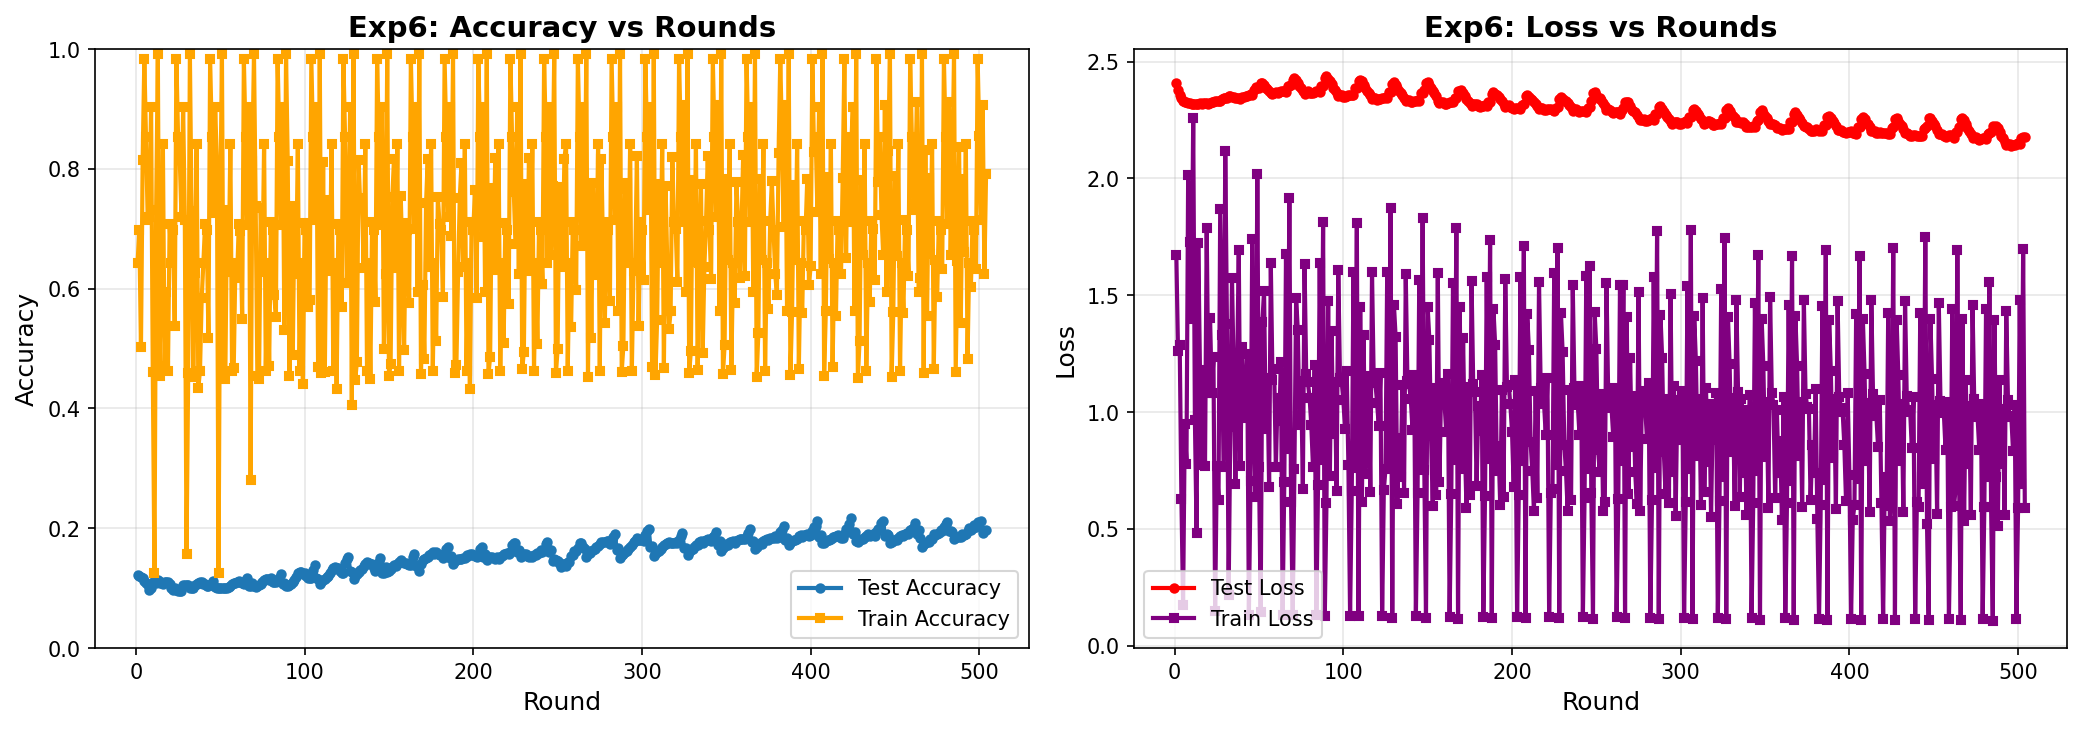

In [86]:
from IPython.display import Image, display
import os

# Assuming comparison_dir is defined from the previous cell's execution
# If not, re-define it based on the environment
if 'IN_COLAB' in globals() and IN_COLAB and OUTPUT_DIR:
    comparison_dir = BASE_OUTPUT_DIR / "logs" / "TrustWeight" / "comparisons"
else:
    comparison_dir = Path("./logs/TrustWeight/comparisons")

print("Displaying Comparison Plots:")

# Display comparison plots
comp_plot_acc_rounds = comparison_dir / "comparison_accuracy_vs_rounds.png"
if os.path.exists(comp_plot_acc_rounds):
    print(f"\n{'-'*50}\nTest Accuracy vs Rounds (All Experiments)")
    display(Image(filename=comp_plot_acc_rounds))
else:
    print(f"Warning: Comparison plot not found: {comp_plot_acc_rounds}")

comp_plot_acc_time = comparison_dir / "comparison_accuracy_vs_time.png"
if os.path.exists(comp_plot_acc_time):
    print(f"\n{'-'*50}\nTest Accuracy vs Wall Clock Time (All Experiments)")
    display(Image(filename=comp_plot_acc_time))
else:
    print(f"Warning: Comparison plot not found: {comp_plot_acc_time}")

# Display individual experiment plots as requested
print("\nDisplaying Individual Experiment Plots (Accuracy vs Rounds):")
# Ensure 'all_data' is available, it should be from the previous cell
if 'all_data' in globals() and len(all_data) > 0:
    for exp_id, exp_data in all_data.items():
        run_dir = exp_data['run_dir']
        plot_path = run_dir / "1_accuracy_loss_vs_rounds.png"
        if os.path.exists(plot_path):
            print(f"\n{'-'*50}\n{exp_id}: Accuracy & Loss vs Rounds")
            display(Image(filename=plot_path))
        else:
            print(f"Warning: Plot not found for {exp_id}: {plot_path}")
else:
    print("Warning: 'all_data' not found. Please ensure Section 11 has been run.")






